# Assignment 3 - Supervised Learning: model training and evaluation

## *Luopeiwen Yi*
Netid: ly178

*Names of students you worked with on this assignment*: Gavin Li

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://kylebradbury.github.io/ids705/notebooks/assignment_instructions.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.metrics import log_loss, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_recall_curve

import warnings

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

%config InlineBackend.figure_format = 'retina'

# 1
## Classification using logistic regression: build it from the ground up
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood. Express this cost as an average cost per sample (i.e. divide your final value by $N$), and use this quantity going forward as the cost function to optimize.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. 
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [56]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None  # logistic regression weights
        self.saved_w = []  # Since this is a small problem, we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves
        # returns nothing
        pass

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        # returns the value of the sigmoid
        pass

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        # returns the average cross entropy cost
        pass

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns a scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        pass

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        # Note the verbose flag enables you to print out the weights at each iteration
        #  (optional - but may help with one of the questions)

        # returns nothing
        pass

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        pass

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        pass

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        pass

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones (a column that is the new column 0)
        pass

**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insights about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-0}, 10^{-2}, 10^{-4}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). All of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the **same set of axes** to enable direct comparison. *Note: make sure you're using average cost per sample, not the total cost*.
- Try running this process for a really big learning rate for this problem: $10^2$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. Either print these first 50 iterations as console output or plot them. What happens? How does the output compare to that corresponding to a learning rate of $10^0$ and why?
- What is the impact that the different values of learning have on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make four plots: two for logistic regression and two for KNN. For each model have one plot showing the training data used for fitting the model, and the other showing the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them. You should not plot one curve for each fold of k-folds; instead, you should plot one ROC curve for Logistic Regression and one for KNN (each should incorporate all 10 folds of validation). Also, don't forget to plot the "chance" line.
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

In [57]:
# load the data
import matplotlib.pyplot as plt

flower = pd.read_csv("A3_Q1_data.csv")

flower.head()

,x1,x2,y
0,2.553124,0.337757,0
1,-0.877757,0.045790,1
2,-0.903528,0.368076,1
3,-1.532152,-0.863737,1
4,-0.046954,-0.388761,1


In [58]:
# Separate features and labels
X = flower[["x1", "x2"]]
y = flower["y"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

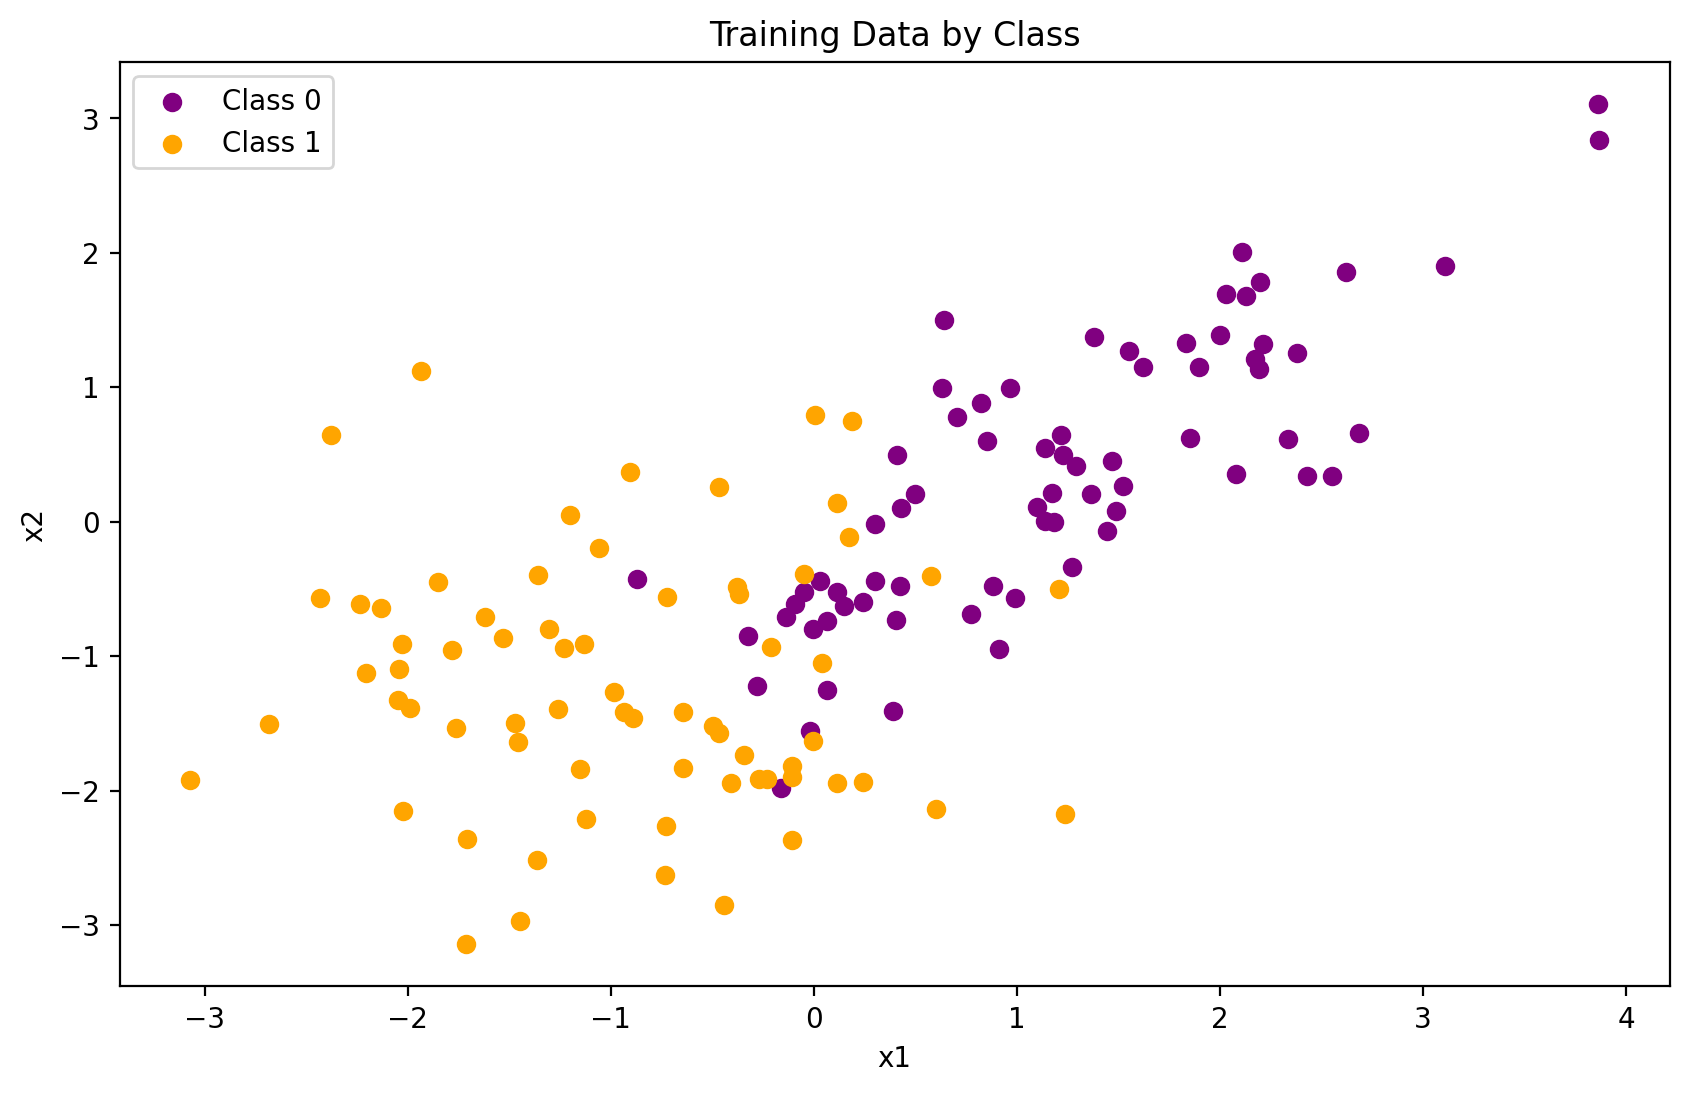

In [ ]:
# Plot the training data by class
plt.figure(figsize=(10, 6))

# plot class 0 data
plt.scatter(
    X_train[y_train == 0]["x1"],
    X_train[y_train == 0]["x2"],
    color="purple",
    label="Class 0",
)

# plot class 1 data
plt.scatter(
    X_train[y_train == 1]["x1"],
    X_train[y_train == 1]["x2"],
    color="orange",
    label="Class 1",
)

plt.title("Training Data by Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

> The data appears to be sperable. Logistic regression is a good choice for these data because the data has binary class labels, either class 0 or class 1, and the plot shows that the two calssess are nearly linearly separable, meaning it's possible to seperate the two classes with a linear boundary.

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

In [60]:
# check is the data has any missing value
missing_values = flower.isnull().sum()
print(f"Count of missing values in x1, x2, and y in the dataset:\n{missing_values}")

Count of missing values in x1, x2, and y in the dataset:
x1    0
x2    0
y     0
dtype: int64


In [61]:
# check any scale differences
print(f"Summary statistics of the dataset:\n{flower.describe()}")

Summary statistics of the dataset:
               x1          x2           y
count  200.000000  200.000000  200.000000
mean     0.151376   -0.385426    0.485000
std      1.411722    1.217490    0.501029
min     -3.210005   -3.193456    0.000000
25%     -0.912029   -1.341047    0.000000
50%      0.112286   -0.479684    0.000000
75%      1.174400    0.495114    1.000000
max      3.867647    3.103541    1.000000


> The minimum and maximum values of $x_1$ are -3.210 and 3.868, standard deviation is around 1.41, mean is around 0.15. The minimum and maximum values of $x_2$  are -3.193 and 3.104, standard deviation is around 1.217, mean is around -0.39. Therefore, both $x_1$ and $x_2$ have mean close to 0, standard deviation close to 1, both have a similar range of values and variability, indicating no significant scale differences and no need for normalization.

In [62]:
# check any duplicate rows
duplicate_rows = flower.duplicated().sum()
print(f"Number of Duplicate Rows:\n{duplicate_rows}")

Number of Duplicate Rows:
0


> As a conclusion, there is no missing value or duplicate rows in the data, and there appears to be no scale differences since x1 and x2 has vary similar range of a variables. Both $x_1$ and $x_2$ have mean close to 0, standard deviation close to 1, indicating no need for normalization. Therefore, no preprocessing is needed.

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

The likelihood for one observation $(y_i, \mathbf{x}_i)$:
$$
L\left(\boldsymbol{w} \mid y_i, \boldsymbol{x}_i\right)=P\left(y_i=1 \mid \boldsymbol{x}_i\right)^{y_i} P\left(y_i=0 \mid \boldsymbol{x}_i\right)^{1-y_i}
$$

The likelihood for all observations $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$:
$$
L(\boldsymbol{w} \mid \boldsymbol{y}, \boldsymbol{X})=P\left(y_1, y_2, \ldots, y_N \mid \boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_N\right)=\prod_{i=1}^N P\left(y_i \mid \boldsymbol{x}_i\right)=\prod_{i=1}^N P\left(y_i=1 \mid \boldsymbol{x}_i\right)^{y_i} P\left(y_i=0 \mid \boldsymbol{x}_i\right)^{1-y_i} \\
\text { Substituting: } \begin{array}{l}
P\left(y_i=1 \mid x_i\right)=\sigma\left(\boldsymbol{w}^T x_i\right) \\
P\left(y_i=0 \mid x_i\right)=1-\sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)
\end{array} \\
=\prod_{i=1}^N \sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)^{y_i}\left[1-\sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)\right]^{1-y_i}\\
\text { Substituting: } \begin{array}{l}
w^{\top} x_i=w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_{i, 2}
\end{array} \\
=\prod_{i=1}^N \sigma\left(w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_ {i, 2}\right)^{y_i}\left[1-\sigma\left(w_0 x_{i, 0}+w_1 x_ {i, 1}+w_2 x_{i, 2}\right)\right]^{1-y_i}
$$

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood. Express this cost as an average cost per sample (i.e. divide your final value by $N$), and use this quantity going forward as the cost function to optimize.

$$
L(\boldsymbol{w} \mid \boldsymbol{y}, \boldsymbol{X})=\prod_{i=1}^N \sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)^{y_i}\left[1-\sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)\right]^{1-y_i}=\prod_{i=1}^N \sigma\left(w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_ {i, 2}\right)^{y_i}\left[1-\sigma\left(w_0 x_{i, 0}+w_1 x_ {i, 1}+w_2 x_{i, 2}\right)\right]^{1-y_i}
$$

$=\prod_{i=1}^N \hat{y}_i^{y_i}\left[1-\hat{y}_i\right]^{1-y_i} \quad$ assuming $\quad \hat{y}_i \triangleq \sigma\left(\boldsymbol{w}^T \boldsymbol{x}_i\right)$

Take the log of both sides:
$$
\begin{aligned}
& \log L(\boldsymbol{w} \mid \boldsymbol{y}, \boldsymbol{X})=\log \left[\prod_{i=1}^N \hat{y}_i{ }^{y_i}\left[1-\hat{y}_i\right]^{1-y_i}\right]=\sum_{i=1}^N \log \left(\hat{y}_i{ }^{y_i}\left[1-\hat{y}_i\right]^{1-y_i}\right) \\
& =\sum_{i=1}^N y_i \log \left(\hat{y}_i\right)+\left(1-y_i\right) \log \left(1-\hat{y}_i\right) \\
\end{aligned}
$$

Define cost function: 
$$
C(\boldsymbol{w})=-\log L(\boldsymbol{w} \mid \boldsymbol{y}, \boldsymbol{X})
$$
$$
C(\boldsymbol{w})=-\left[\sum_{i=1}^N y_i \log \left(\hat{y}_i\right)+\left(1-y_i\right) \log \left(1-\hat{y}_i\right)\right]
$$

Normalize this quantity by dividing by N for interpreting the results as mean cost per sample:
$$
C(\boldsymbol{w})=-\frac{1}{N}\left[\sum_{i=1}^N y_i \log \left(\hat{y}_i\right)+\left(1-y_i\right) \log \left(1-\hat{y}_i\right)\right]=-\frac{1}{N}\left[\sum_{i=1}^N y_i \log \left(\sigma\left(w^{\top} x_i\right)+\left(1-y_i\right) \log \left(1-\sigma\left(w^{\top} x_i\right)\right)\right)\right]
$$

Substituting $w^{\top} x_i=w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_{i, 2}$
knowing $x_{i,0} \triangleq 1$
$$
=-\frac{1}{N}\left[\sum_{i=1}^N y_i \log \left(\sigma\left(w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_ {i, 2}\right)\right)+\left(1-y_i\right) \log \left(1-\sigma\left(w_0 x_{i, 0}+w_1 x_{i, 1}+w_2 x_ {i, 2}\right)\right)\right]
$$


**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

The formula for the partial derivative of the cost function with respect to weight $w_j$ is:

$$
\frac{\partial C}{\partial w_j}=-\frac{1}{N} \sum_{i=1}^N\left[y_i \frac{1}{\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)} \sigma^{\prime}\left(\mathbf{w}^{\top} \mathbf{x}_i\right) x_{i, j}-\left(1-y_i\right) \frac{1}{1-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)} \sigma^{\prime}\left(\mathbf{w}^{\top} \mathbf{x}_i\right) x_{i, j}\right]
$$

The logistic function $\sigma$ is defined as:
$$
\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)=\frac{1}{1+e^{-\mathbf{w}^{\top} \mathbf{x}_i}}
$$

The derivative of the logistic function with respect to $\mathbf{w}^{\top} \mathbf{x}_i$ is:
$$
\sigma^{\prime}\left(\mathbf{w}^{\top} \mathbf{x}_i\right)=\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\left(1-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right)
$$

Simplifying the formula for the partial derivative of the cost function with respect to weight $w_j$ using the derivative of the logistic function:

$$
\frac{\partial C}{\partial w_j}=-\frac{1}{N} \sum_{i=1}^N\left[y_i \frac{1}{\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)} \sigma^{\prime}\left(\mathbf{w}^{\top} \mathbf{x}_i\right) x_{i, j}-\left(1-y_i\right) \frac{1}{1-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)} \sigma^{\prime}\left(\mathbf{w}^{\top} \mathbf{x}_i\right) x_{i, j}\right]
$$

$$
\frac{\partial C}{\partial w_j}=-\frac{1}{N} \sum_{i=1}^N\left[y_i\left(1-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right) x_{i, j}-\left(1-y_i\right) \sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right) x_{i, j}\right]
$$

$$
\frac{\partial C}{\partial w_j}=-\frac{1}{N} \sum_{i=1}^N\left[y_i-y_i \sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)+y_i \sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right] x_{i, j}
$$

$$
\frac{\partial C}{\partial w_j}=-\frac{1}{N} \sum_{i=1}^N\left[y_i-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right] x_{i, j}
$$

The cost function's gradient components with respect to the weights $w_0, w_1, w_2$ are given by:

For $w_0$, where $x_{i, j}$ becomes $x_{i, 0}$ which equals to 1:
$$
\frac{\partial C}{\partial w_0}=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right) \cdot 1
$$

For $w_1$, where $x_{i, j}$ becomes $x_{i, 1}$:
$$
\frac{\partial C}{\partial w_1}=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right) x_{i, 1}
$$

For $w_2$, where $x_{i, j}$ becomes $x_{i, 2}$:
$$
\frac{\partial C}{\partial w_2}=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right) x_{i, 2}
$$

Therefore, the gradient vector $\nabla_w C(w)$ is:
$$
\nabla_w C(w)=\left[\begin{array}{c}
\frac{\partial C}{\partial w_0} \\
\frac{\partial C}{\partial w_1} \\
\frac{\partial C}{\partial w_2}
\end{array}\right]=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\sigma\left(\mathbf{w}^{\top} \mathbf{x}_i\right)\right)\left[\begin{array}{c}
1 \\
x_{i, 1} \\
x_{i, 2}
\end{array}\right]
$$

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

Update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$:

$\begin{aligned} w_j^{(k+1)} & =w_j^{(k)}-\eta \nabla_{w_j} C\left(w^{(k)}\right) \\ w_j^{(k+1)} & =w_j^{(k)}-\eta \frac{\partial C}{\partial w_j} \\ w_j^{(k+1)} & =w_j^{(k)}-\eta\left(-\frac{1}{N} \sum_{i=1}^N\left[y_i-\sigma\left(w^{(k)^{\top}} x_i\right)\right] x_{i, j}\right)\end{aligned}$


The gradient descent updated equation in vectorized form is:
$$
\left[\begin{array}{l}
w_0^{(k+1)} \\
w_1^{(k+1)} \\
w_2^{(k+1)}
\end{array}\right]=\left[\begin{array}{l}
w_0^{(k)} \\
w_1^{(k)} \\
w_2^{(k)}
\end{array}\right]-\eta\left[\begin{array}{l}
\frac{\partial C}{\partial w_0} \\
\frac{\partial C}{\partial w_1} \\
\frac{\partial C}{\partial w_2}
\end{array}\right]
$$

One equation for each model logistic regression model parameter:
$$
\begin{gathered}
w_0^{(k+1)}=w_0^{(k)}-\eta\left(-\frac{1}{N} \sum_{i=1}^N\left[y_i-\sigma\left(w^{(k)^{\top}} x_i\right)\right]\right) \\
w_1^{(k+1)}=w_1^{(k)}-\eta\left(-\frac{1}{N} \sum_{i=1}^N\left[y_i-\sigma\left(w^{(k)^{\top}} x_i\right)\right] x_{i, 1}\right) \\
w_2^{(k+1)}=w_2^{(k)}-\eta\left(-\frac{1}{N} \sum_{i=1}^N\left[y_i-\sigma\left(w^{(k)^{\top}} x_i\right)\right] x_{i, 2}\right)
\end{gathered}
$$



### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. 
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [63]:
# Logistic regression class
class Logistic_regression:
    """
    Implements logistic regression for
    binary classification using gradient descent.
    """

    # Class constructor
    def __init__(self):
        """
        Initializes the logistic regression model with default parameters.
        """
        self.w = None  # logistic regression weights
        self.saved_w = []  # Save the weights
        #  at each iteration of gradient descent to build
        #  learning curves
        self.fitted = False  # Flag to indicate whether the model is fitted
        # returns nothing

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        """
        Calculates the sigmoid function of w^T X for an input set of weights.
        """
        # Calculate the dot product of w and X
        z = np.dot(X, w)
        # Return the value of the sigmoid
        return 1 / (1 + np.exp(-z))

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        """
        Calculates the cost function for an input set of weights.
        """
        # calculate the prediction using sigmoid function
        y_hat = self.sigmoid(X, w)
        # Adjust predictions slightly to avoid exact 1.0 or 0.0
        # setting 1s to 0.999999 and 0s to 0.000001.
        y_hat[y_hat == 1] = 1 - 1e-6
        y_hat[y_hat == 0] = 1e-6
        # returns the average cross entropy cost
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        """
        Updates the weights in an iteration of gradient descent.
        """
        # calculate the predictions using sigmoid function
        y_hat = self.sigmoid(X, self.w)
        # Compute the gradient for logistic regression
        gradient = -np.dot(X.T, (y - y_hat)) / y.size
        # Update the weights
        self.w -= lr * gradient
        # Save the weights
        self.saved_w.append(np.copy(self.w))
        # returns a scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        weight_change = np.linalg.norm(lr * gradient)

        return weight_change

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        """
        Fits the logistic regression model to the data through gradient descent.
        """
        self.saved_w = []  # Clears previous runs' saved weights
        # Randomly initialize the weights to values between 0 and 1
        np.random.seed(38)  # set random seed
        w_init = np.random.rand(X.shape[1])
        self.w = w_init
        # save the initial weight
        self.saved_w.append(np.copy(w_init))
        # loop through iterations
        # stopping criteria 2
        for i in range(max_iter):
            weight_change = self.gradient_descent(X, y, lr)
            # stopping criteria 1
            if weight_change < delta_thresh:
                break
            # the verbose flag enables you to print out the weights at each iteration
            if verbose:
                print(f"Iteration {i}: Weights {self.w}")
        self.fitted = True  # Set to True after fitting
        # returns nothing

    # check if the model is successfully fitted
    def fitted_or_not(self):
        """
        Checks if the model is successfully fitted.
        """
        print(f"The model is fitted: {self.fitted}.")

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        """
        Uses the trained model to predict
        the confidence scores (probability of the positive class).
        """
        # returns the confidence score for the each sample
        return self.sigmoid(X, self.w)

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        """
        Uses the trained model to make binary predictions.
        """
        # returns a binary prediction for each sample
        y_hat = self.predict_proba(X)
        y_predicted_cls = [1 if i > thresh else 0 for i in y_hat]

        return np.array(y_predicted_cls)

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        """
        Stores the learning curves from saved weights from gradient descent.
        """
        # Save the cost at each iteration
        cost_history = [self.cost(X, y, w) for w in self.saved_w]
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        return cost_history

    def weight_history(self):
        """
        Returns the history of weights saved during the fitting process.
        """
        return self.saved_w

    # Appends a column of ones as the first feature to account for the bias term
    # preprocess X before calling fit
    def prepare_x(self, X):
        """
        Prepares the feature matrix X by appending a column
        of ones as the first feature to account for the bias term.
        """
        # create a new column of ones with the same number of rows as X
        new_column_1 = np.ones((X.shape[0], 1))
        # combining the newly created column of ones with the original feature matrix X
        # returns the X with a new feature of all ones (a column that is the new column 0)
        return np.hstack((new_column_1, X))

**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insights about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-0}, 10^{-2}, 10^{-4}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). All of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the **same set of axes** to enable direct comparison. *Note: make sure you're using average cost per sample, not the total cost*.

In [64]:
regressor = Logistic_regression()

# Preprocess both training and test data
X_train_prepared = regressor.prepare_x(X_train)
X_test_prepared = regressor.prepare_x(X_test)

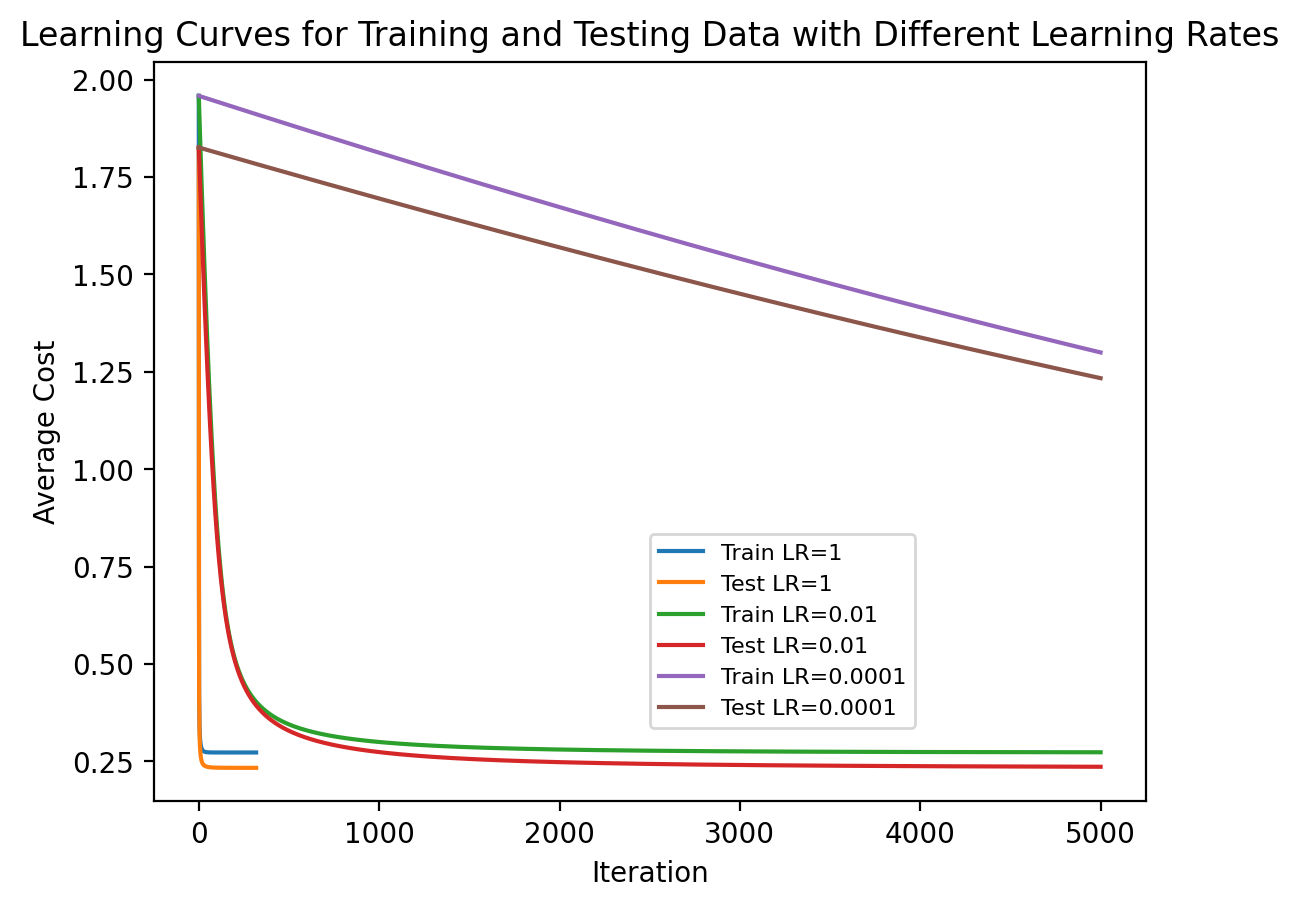

In [65]:
# define list of learning rates
learning_rates = [10**0, 10**-2, 10**-4]
for lr in learning_rates:
    # Fit the model and calculate learning curves for both training and test datasets
    regressor.fit(X_train_prepared, y_train, lr)

    # Plot learning curves
    plt.plot(
        regressor.learning_curve(X_train_prepared, y_train), label=f"Train LR={lr}"
    )
    plt.plot(regressor.learning_curve(X_test_prepared, y_test), label=f"Test LR={lr}")

plt.xlabel("Iteration")
plt.ylabel("Average Cost")
plt.title("Learning Curves for Training and Testing Data with Different Learning Rates")
plt.legend(loc=(0.5, 0.1), fontsize=8)
plt.show()

- Try running this process for a really big learning rate for this problem: $10^2$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. Either print these first 50 iterations as console output or plot them. What happens? How does the output compare to that corresponding to a learning rate of $10^0$ and why?

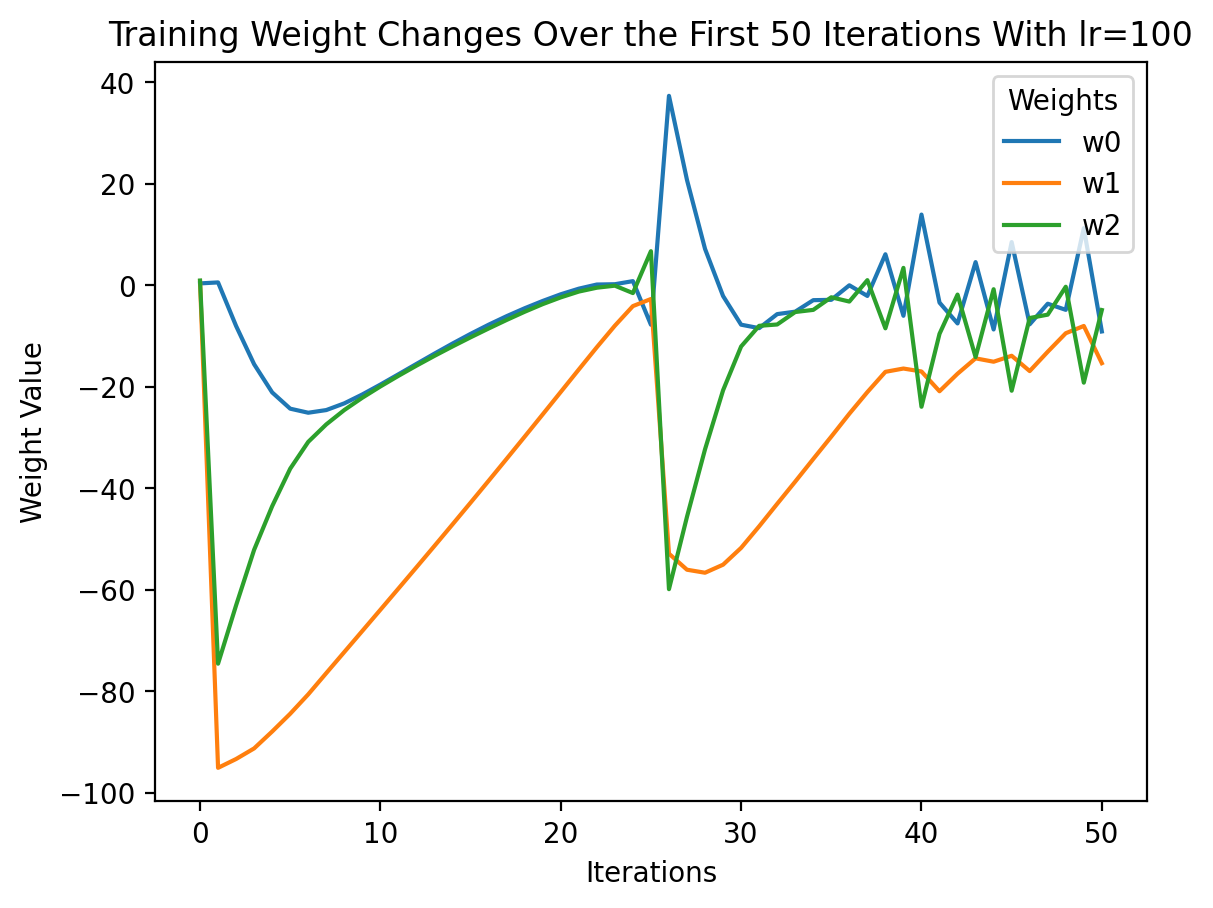

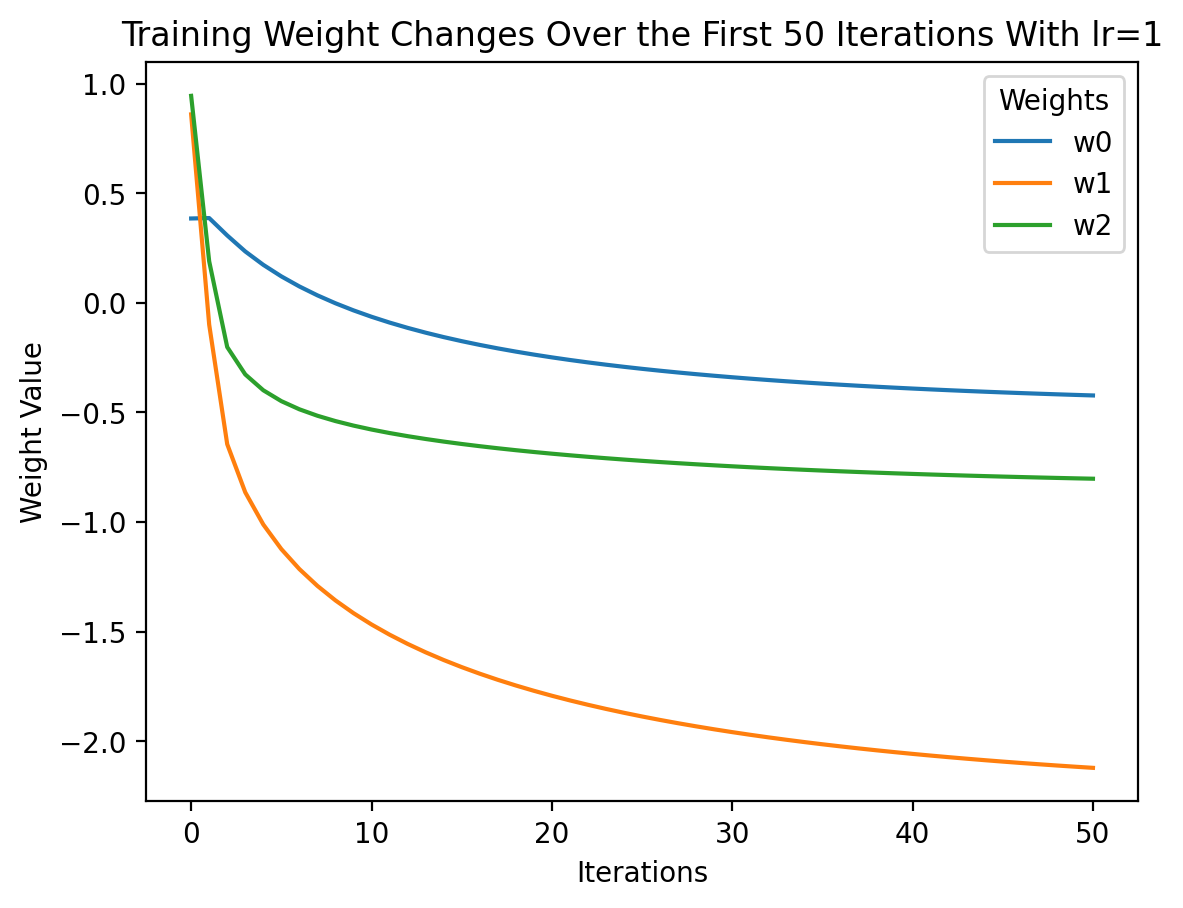

In [68]:
learning_rate = [10**2, 10**0]
for lr in learning_rate:
    # Fit the model for training data with lr
    regressor.fit(X_train_prepared, y_train, lr)

    # get the weight history
    weight_history = regressor.weight_history()
    # Subset the weight history for the first 50 iterations
    weight_history_50 = np.array(weight_history[:51])

    # Extract individual weight histories for w0, w1, and w2
    w0_history = weight_history_50[:, 0]
    w1_history = weight_history_50[:, 1]
    w2_history = weight_history_50[:, 2]

    # Plot the weight histories
    plt.plot(w0_history, label="w0")
    plt.plot(w1_history, label="w1")
    plt.plot(w2_history, label="w2")

    # add labels
    plt.xlabel("Iterations")
    plt.ylabel("Weight Value")
    plt.title(f"Training Weight Changes Over the First 50 Iterations With lr={lr}")
    plt.legend(title="Weights", loc="upper right", fontsize=10)

    plt.show()

> - The two graphs show the changes in the weights of a logistic regression model over the first 50 iterations for two different learning rates: \(10^2\) and \(10^0\). 
> - Looking at the graph for the learning rate of \(10^2\) or 100, we can observe significant fluctuations in the values of the weights (w0, w1, w2). The weights oscillate wildly and do not stabilize, indicating that the learning rate is too high. This causes the gradient descent algorithm to "overshoot" the optimal values, bouncing back and forth and potentially even diverging, as evidenced by the drastic changes in magnitude of the weights. Such behavior can prevent the model from converging to a good solution.
> - In contrast, the graph for the learning rate of \(10^0\) or 1 shows a smoother and more stable convergence. The weights steadily approach a stable value, indicating that the learning rate is more appropriate for this problem. The gradient descent is able to make incremental adjustments to the weights, allowing the cost function to decrease in a controlled manner and the model to converge to an optimal solution.
> - The comparison between the outputs of the two learning rates illustrates the importance of choosing an appropriate learning rate for the convergence of gradient descent. A learning rate that is too large can cause instability and prevent the model from finding the optimal solution, while a learning rate that is too small can slow down the learning process, requiring many more iterations to converge. The learning rate of \(10^0\) or 1 appears to be more suitable for this dataset and model, as it leads to a more stable and consistent convergence within the first 50 iterations.

- What is the impact that the different values of learning have on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

In [69]:
learning_rate = [10 ** (-0), 10 ** (-2), 10 ** (-4), 10**2]
for lr in learning_rate:
    start = time.time()
    regressor.fit(X_train_prepared, y_train, lr)
    end = time.time()
    print(f"Time taken for training the model with lr={lr} is {end - start:.2f}")
    training_average_cost = regressor.learning_curve(X_train_prepared, y_train)
    # get the last value in the training average cost
    last_training_average_cost = training_average_cost[-1]
    print(
        f"Last training average cost with lr={lr} is {last_training_average_cost:.2f}"
    )
    testing_average_cost = regressor.learning_curve(X_test_prepared, y_test)
    last_testing_average_cost = testing_average_cost[-1]
    print(f"Last testing average cost with lr={lr} is {last_testing_average_cost:.2f}")

Time taken for training the model with lr=1 is 0.02
Last training average cost with lr=1 is 0.27
Last testing average cost with lr=1 is 0.23
Time taken for training the model with lr=0.01 is 0.19
Last training average cost with lr=0.01 is 0.27
Last testing average cost with lr=0.01 is 0.24
Time taken for training the model with lr=0.0001 is 0.19
Last training average cost with lr=0.0001 is 1.30
Last testing average cost with lr=0.0001 is 1.23
Time taken for training the model with lr=100 is 0.20
Last training average cost with lr=100 is 2.76
Last testing average cost with lr=100 is 1.27


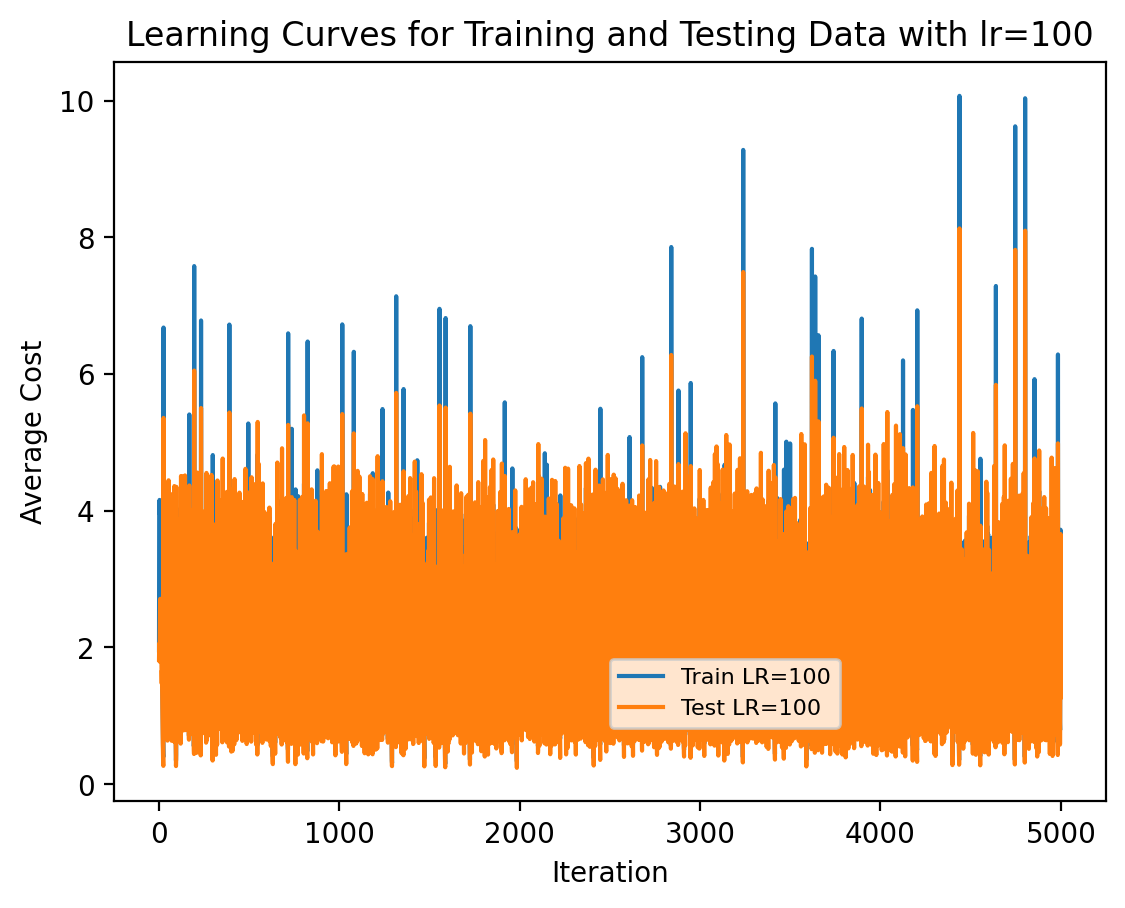

In [70]:
# Fit the model and calculate learning curves
# for both training and test datasets with lr=100
regressor.fit(X_train_prepared, y_train, 100)

# Plot learning curves
plt.plot(regressor.learning_curve(X_train_prepared, y_train), label=f"Train LR=100")
plt.plot(regressor.learning_curve(X_test_prepared, y_test), label=f"Test LR=100")

plt.xlabel("Iteration")
plt.ylabel("Average Cost")
plt.title("Learning Curves for Training and Testing Data with lr=100")
plt.legend(loc=(0.5, 0.1), fontsize=8)
plt.show()

> - The choice of learning rate is a trade-off between convergence speed and the stability/quality of the final model. An optimal learning rate leads to faster convergence to a solution that generalizes well, while extreme values (either too high or too low) can slow down the training process or compromise the model's performance. In this context, learning rate = 1 has the fastest convergence speed and the lowest testing average cost among all, while learning rate = 100 has the slowest convergence speed and the highest testing average cost among all.

> - Based on the provided data, the preferred learning rate would be \(lr=1\) for several reasons:
> - **Generalization to Test Data**: I chose the testing average cost as my metric for evaluating model performance with different learning rates. On the graph titled "Learning Curves for Training and Testing Data with Different Learning Rates," it can be visually observed that the testing average cost for \(lr=1\) is the lowest. After examining the final testing average costs for models with different learning rates, it is evident that the model with \(lr=1\) achieves the lowest final testing average cost of 0.23. This not only is the lowest among all options, but it also suggests that the model generalizes well to unseen data. In contrast, extreme values of \(lr=0.0001\) and \(lr=100\), which achieve testing average costs of 1.23 and 1.27 respectively, indicate that the model with \(lr=1\) has the best ability to predict outcomes on new data accurately. 
> - **Efficiency**: The graph "Learning Curves for Training and Testing Data with Different Learning Rates" shows that the model with \(lr=1\) converges more quickly than any other model. Similarly, the time taken for training with \(lr=1\) is significantly lower (0.02 seconds) compared to the other learning rates, demonstrating that \(lr=1\) is a more efficient training option with the fastest convergence speed.
> - **Stability and Generalization**: The similar performance on both the training and testing datasets suggests that the model with \(lr=1\) generalizes well without overfitting or underfitting, indicating a stable learning process. 
> - In summary, \(lr=1\) offers the most advantageous combination of quick convergence speed and effective learning, suggesting it is the best choice among the provided options.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 

- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.

In [71]:
# fit logistic regression model with learning rate of 1
regressor = Logistic_regression()
regressor.fit(X_train_prepared, y_train, lr=1)

# fit knn model with k=7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [72]:
regressor.fitted_or_not()

The model is fitted: True.


- Using the trained models, make four plots: two for logistic regression and two for KNN. For each model have one plot showing the training data used for fitting the model, and the other showing the test data. On each plot, include the decision boundary resulting from your trained classifier.

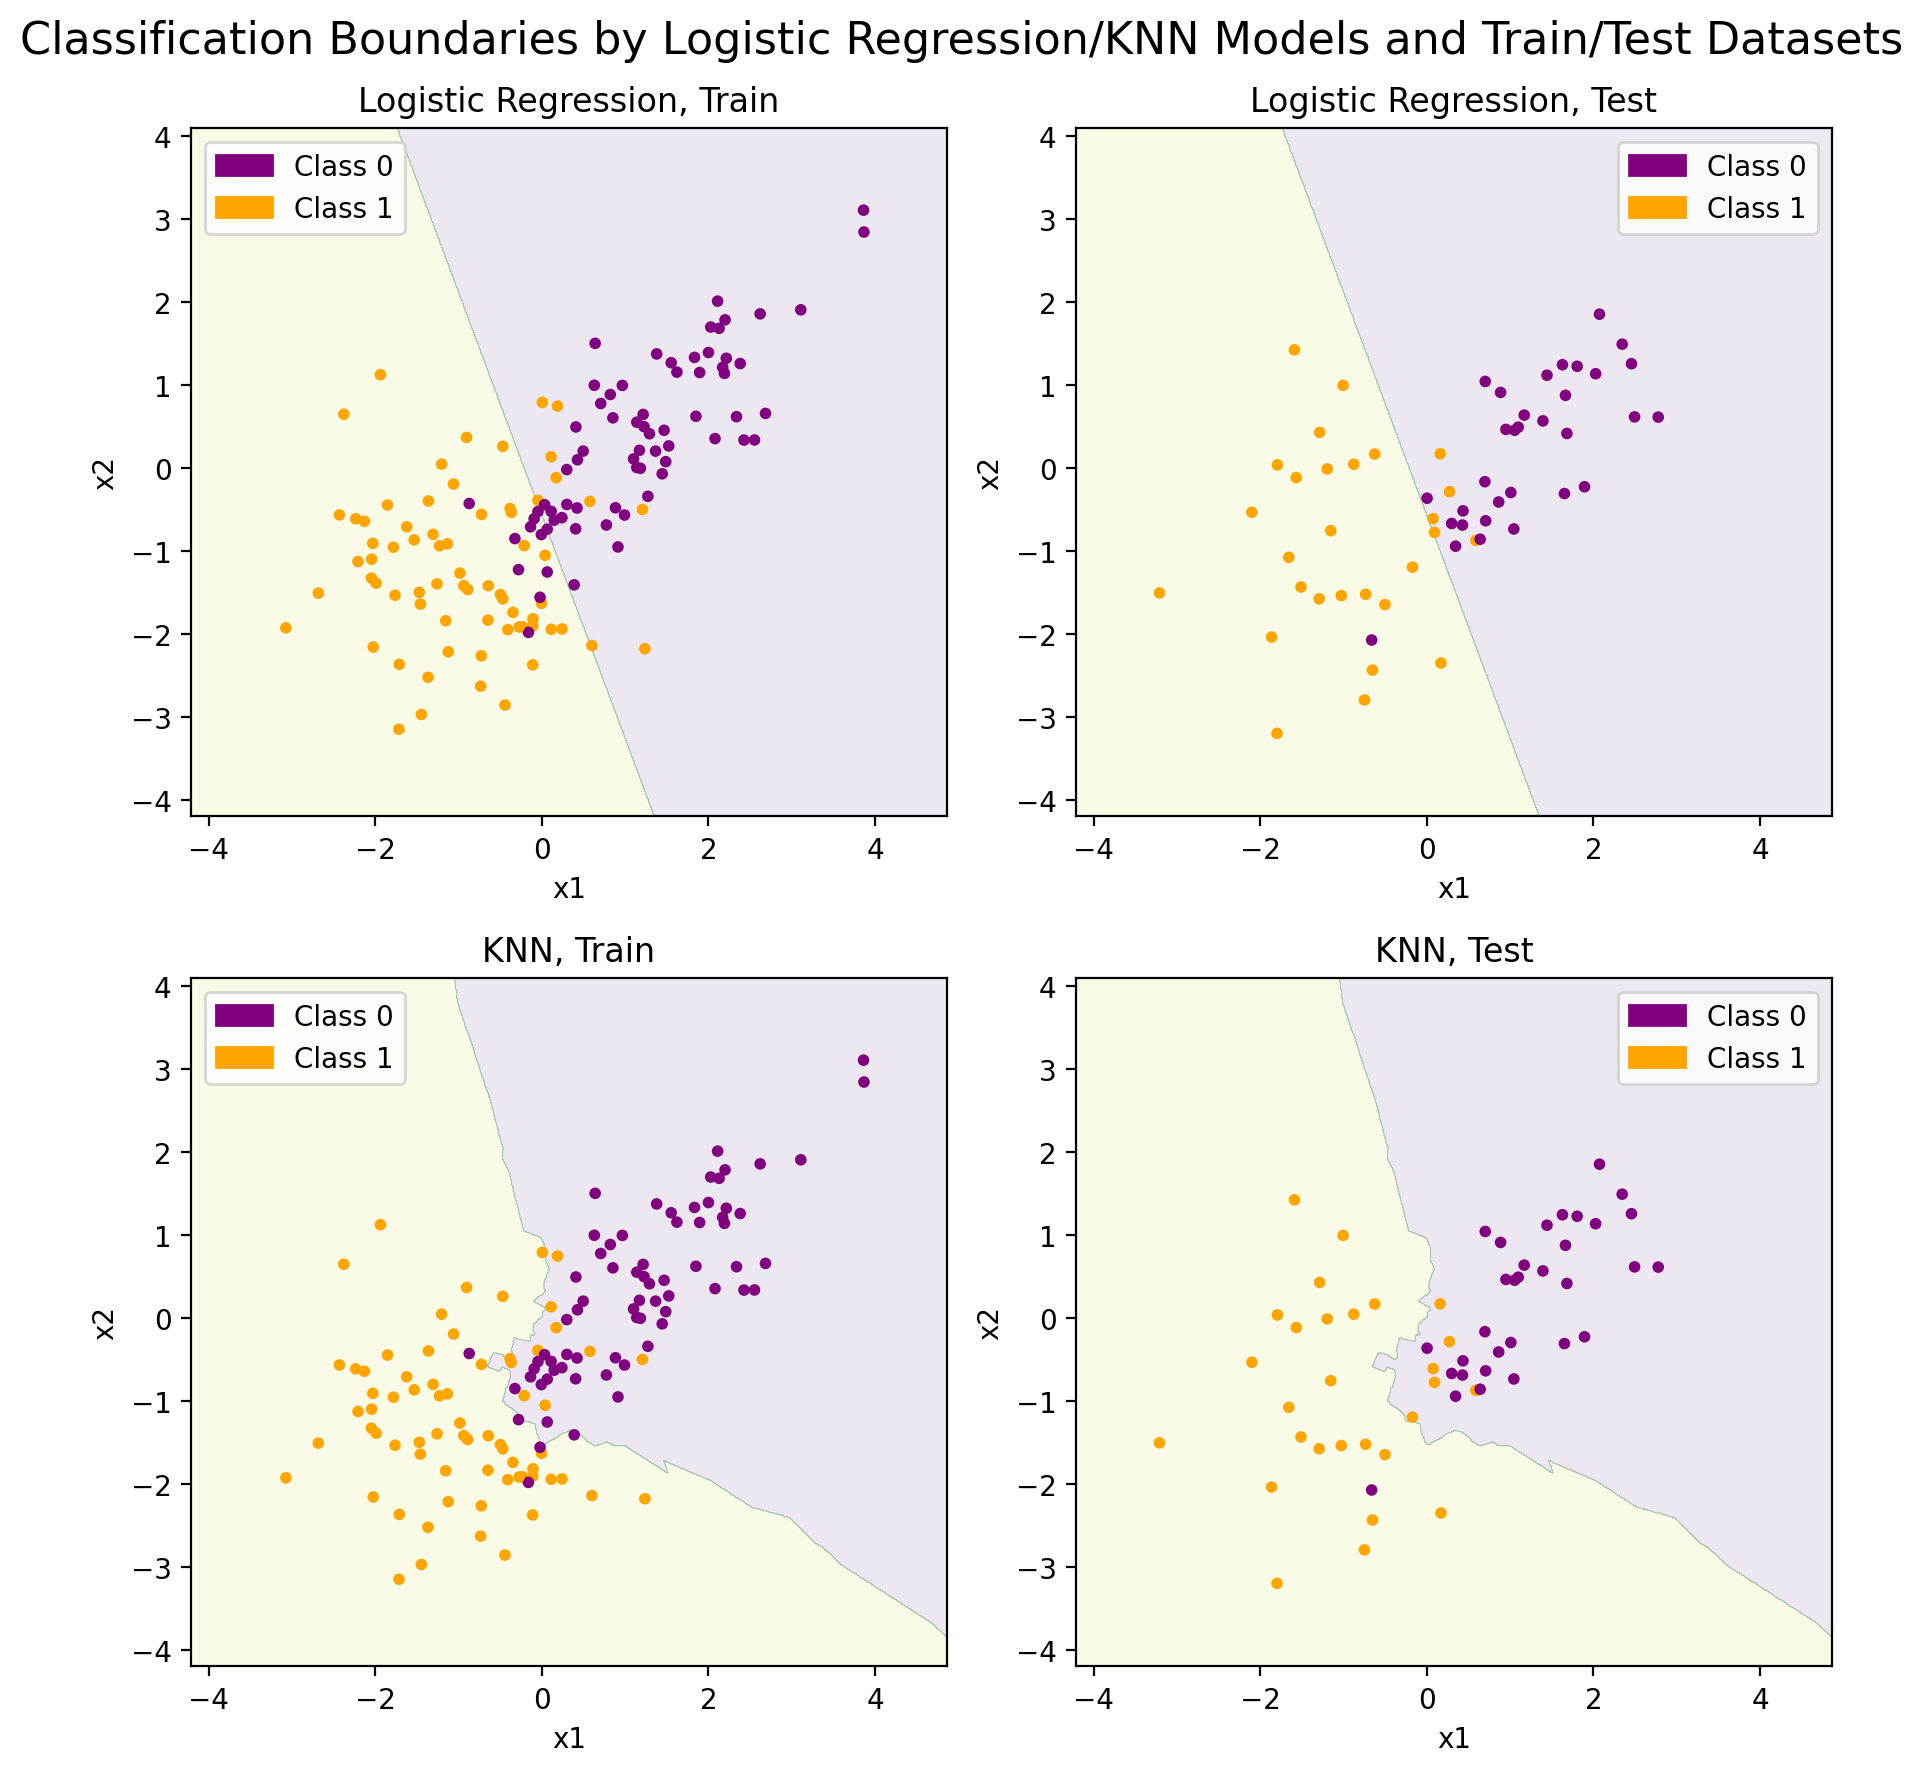

In [73]:
# Plotting

# color map for class classification
color_train = ["purple" if r == 0 else "orange" for r in y_train]
color_test = ["purple" if r == 0 else "orange" for r in y_test]

# boundary preparation using the 'flower' DataFrame
boundary_x1_max, boundary_x1_min = flower["x1"].max() + 1, flower["x1"].min() - 1
boundary_x2_max, boundary_x2_min = flower["x2"].max() + 1, flower["x2"].min() - 1

bound11, bound22 = np.meshgrid(
    np.arange(boundary_x1_min, boundary_x1_max, 0.01),
    np.arange(boundary_x2_min, boundary_x2_max, 0.01),
)

# prediction boundary for logistic regression
z_regressor = regressor.predict(
    regressor.prepare_x(np.c_[bound11.ravel(), bound22.ravel()])
).reshape(bound22.shape)

# prediction boundary for KNN
z_knn = knn.predict(np.c_[bound11.ravel(), bound22.ravel()]).reshape(bound22.shape)

# prepare figure size
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

fig.suptitle(
    "Classification Boundaries by Logistic Regression/KNN Models and Train/Test Datasets",
    fontsize=16,
)

## Logistic Regression, Training Data
axs[0, 0].contourf(bound11, bound22, z_regressor, alpha=0.1, cmap="viridis")
axs[0, 0].scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], color=color_train, s=10)
axs[0, 0].set_title("Logistic Regression, Train")
axs[0, 0].set_xlabel("x1")
axs[0, 0].set_ylabel("x2")

## KNN, Training Data
axs[1, 0].contourf(bound11, bound22, z_knn, alpha=0.1, cmap="viridis")
axs[1, 0].scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], color=color_train, s=10)
axs[1, 0].set_title("KNN, Train")
axs[1, 0].set_xlabel("x1")
axs[1, 0].set_ylabel("x2")

## Logistic Regression, Test Data
axs[0, 1].contourf(bound11, bound22, z_regressor, alpha=0.1, cmap="viridis")
axs[0, 1].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], color=color_test, s=10)
axs[0, 1].set_title("Logistic Regression, Test")
axs[0, 1].set_xlabel("x1")
axs[0, 1].set_ylabel("x2")

## KNN, Test Data
axs[1, 1].contourf(bound11, bound22, z_knn, alpha=0.1, cmap="viridis")
axs[1, 1].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], color=color_test, s=10)
axs[1, 1].set_title("KNN, Test")
axs[1, 1].set_xlabel("x1")
axs[1, 1].set_ylabel("x2")

# Add legend patches
class_1_patch = mpatches.Patch(color="purple", label="Class 0")
class_2_patch = mpatches.Patch(color="orange", label="Class 1")

# Adding the same legend to all subplots
for ax in axs.flat:
    ax.legend(handles=[class_1_patch, class_2_patch])

plt.tight_layout()
plt.show()

- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them. You should not plot one curve for each fold of k-folds; instead, you should plot one ROC curve for Logistic Regression and one for KNN (each should incorporate all 10 folds of validation). Also, don't forget to plot the "chance" line.
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.

In [74]:
# Initialize StratifiedKFold with k fold=10
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
skf.get_n_splits(X, y)

print("The number of folds is:", skf.get_n_splits(X, y))

The number of folds is: 10


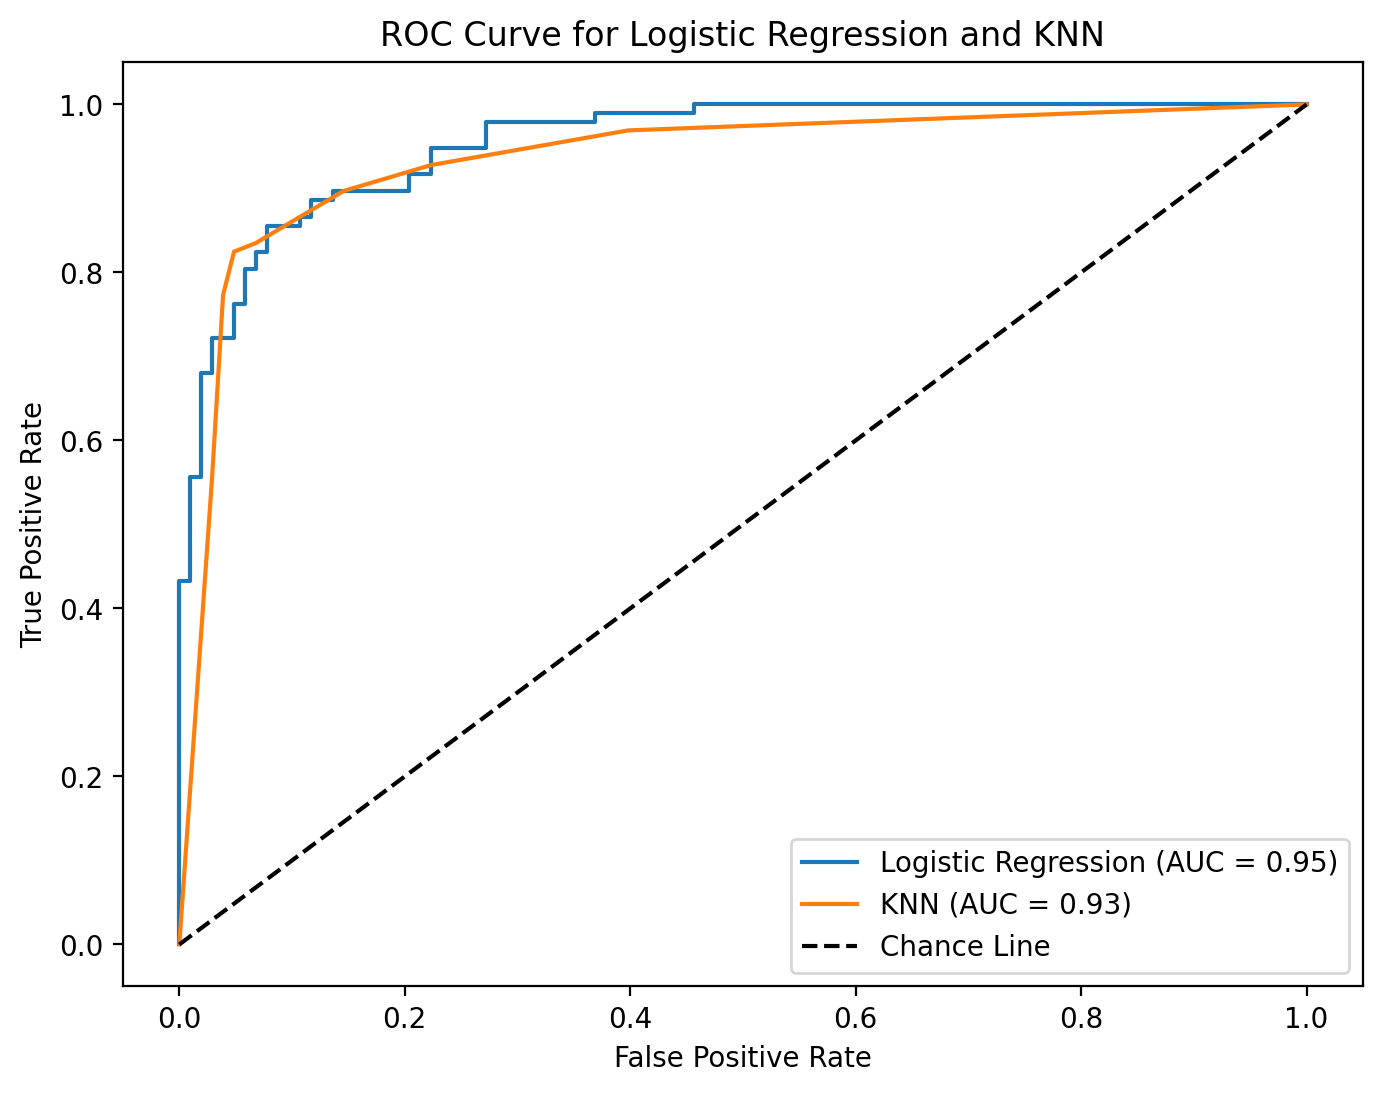

In [75]:
# Lists to hold all true labels and prediction scores
true_labels = []
regressor_scores = []
knn_scores = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    x_train_k, x_validation_k = X.iloc[train_index], X.iloc[test_index]
    y_train_k, y_validation_k = y.iloc[train_index], y.iloc[test_index]

    # Logistic Regression
    regressor = Logistic_regression()
    X_train_k_prepared = regressor.prepare_x(x_train_k)
    X_validation_k_prepared = regressor.prepare_x(x_validation_k)
    regressor.fit(X_train_k_prepared, y_train_k, lr=0.01)
    # Returns probabilities for logistic regression positive class
    regressor_probs = regressor.predict_proba(X_validation_k_prepared)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(x_train_k, y_train_k)
    # Returns probabilities for KNN positive class
    knn_probs = knn.predict_proba(x_validation_k)[:, 1]

    # Store true labels
    true_labels.extend(y_validation_k)
    # Store probabilities for logistic regression positive class
    regressor_scores.extend(regressor_probs)
    # Store probabilities for KNN positive class
    knn_scores.extend(knn_probs)

# Compute ROC curves for logistic regression and knn
fpr_regressor, tpr_regressor, _ = roc_curve(true_labels, regressor_scores)
fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_scores)

# Compute AUC scores for logistic regression and knn
regressor_auc = roc_auc_score(true_labels, regressor_scores)
knn_auc = roc_auc_score(true_labels, knn_scores)

# Plotting
plt.figure(figsize=(8, 6))
# plot ROC curve
plt.plot(
    fpr_regressor,
    tpr_regressor,
    label=f"Logistic Regression (AUC = {regressor_auc:.2f})",
)
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {knn_auc:.2f})")
# plot black chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance Line")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression and KNN")
plt.legend(loc="lower right")
plt.show()

- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

> - The purpose of cross-validation for this problem is to estimate the generalization performance of both the logistic regression and KNN models while mitigating the risk of overfitting by validating the models on multiple subsets of data. It aids in selecting the model with the best generalization ability.
> - In the decision boundary graph, the logistic regression model has a linear decision boundary, while the KNN model has a more complex boundary. On the training dataset, KNN performs better at classifying data than the logistic regression model; however, on the testing dataset, the logistic regression model outperforms KNN at classifying unseen data. This suggests that the logistic regression model is a better classifier than KNN since KNN appears to overfit the training data.
> - On the ROC curve graph, the logistic regression model has an AUC of 0.95, while the KNN model has an AUC of 0.93. The higher the AUC, the better the model is at distinguishing between the positive and negative classes. Since the logistic regression model has a slightly higher AUC, it indicates superior performance as a classifier compared to KNN.
> - Overall, the logistic regression model, with its simpler linear decision boundary, is less prone to overfitting compared to the more complex boundary created by the KNN model. The logistic regression model's slightly higher AUC value suggests better performance on this dataset. Therefore, based on the provided ROC curves and decision boundaries, I would select the logistic regression model for application to previously unseen data for this problem.

# 2

## Digits classification
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 


**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

**(c)** Identify the value of the regularization parameter that optimizes model performance on out-of-sample data. Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance on the test set over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at least 20 different values of C. As you vary the regularization coefficient, Plot the following four quantities (this should result in 4 separate plots)... 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
-Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. For the ROC curves, all your curves should be plotted on the same set of axes so that you can directly compare them. Please do the same wih the PR curves.
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead, you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise, your results may not converge.
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [3]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first time and False after the first time
# so that you just load the data locally instead
download_data = True

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y != "3"] = 0
    y[y == "3"] = 1
    y = y.astype("int")

    # Divide the data into a training and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 / 7, random_state=88
    )

    file = open("tmpdata", "wb")
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open("tmpdata", "rb")
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

**ANSWER**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 

In [3]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first time and False after the first time
#   so that you just load the data locally instead
download_data = True

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y != "3"] = 0
    y[y == "3"] = 1
    y = y.astype("int")

    # Divide the data into a training and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 / 7, random_state=88
    )

    file = open("tmpdata", "wb")
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open("tmpdata", "rb")
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

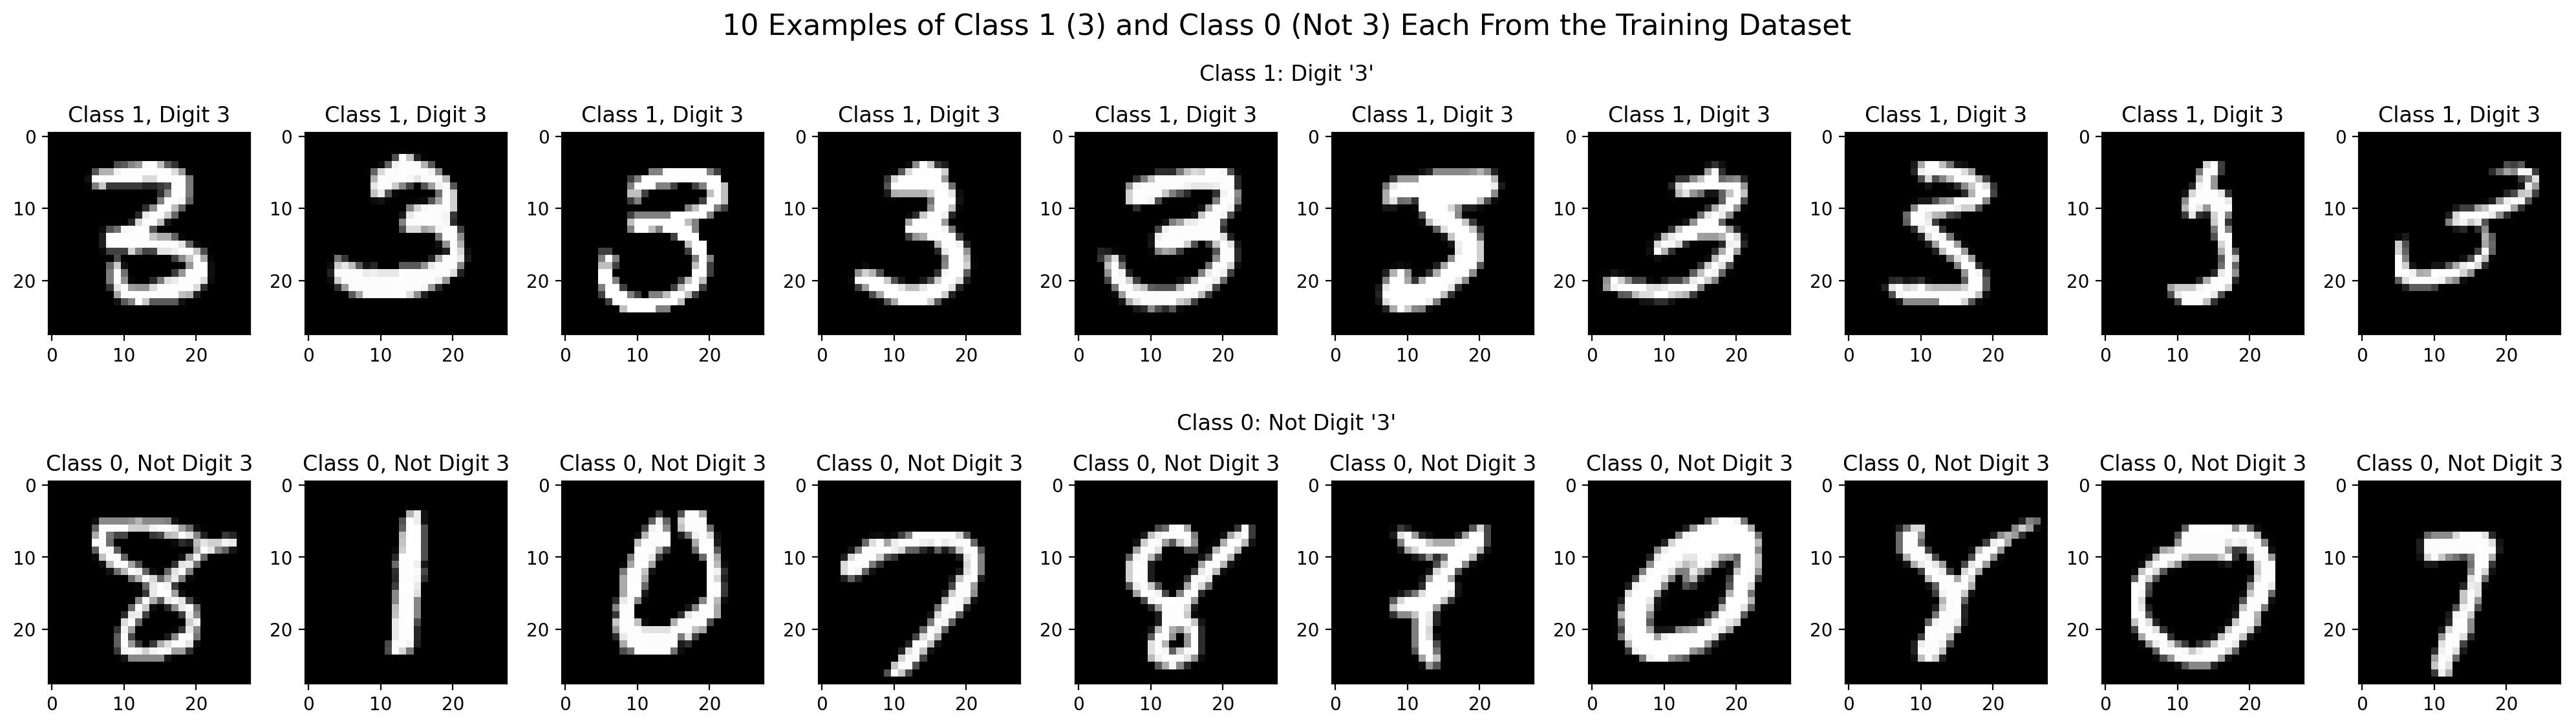

In [78]:
# Initialize figure for plotting
plt.figure(figsize=(20, 6))

# Set Variables to track the
# number of examples plotted for each class
examples = 10
count_3s = 0
count_not_3s = 0

plt.suptitle(
    "10 Examples of Class 1 (3) and Class 0 (Not 3) Each From the Training Dataset",
    fontsize=16,
)

# Loop over the training dataset and plot
# until have 10 examples of each class
for i in range(len(X_train)):
    # Plot examples of class '3'
    if y_train[i] == 1 and count_3s < examples:
        plt.subplot(2, examples, count_3s + 1)
        # reshape the data to be 28 x 28
        plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
        # plt.axis("off")
        plt.title("Class 1, Digit 3")
        count_3s += 1

    # Plot examples of class '0' (not '3')
    elif y_train[i] == 0 and count_not_3s < examples:
        plt.subplot(2, examples, examples + count_not_3s + 1)
        # reshape the data to be 28 x 28
        plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
        # plt.axis("off")
        plt.title("Class 0, Not Digit 3")
        count_not_3s += 1

    # Break the loop if have 10 examples of both classes
    if count_3s >= examples and count_not_3s >= examples:
        break

# adjust subplot parameters to give specified padding
plt.subplots_adjust(top=0.8)

# Adding text annotations as subtitles for each row
plt.figtext(0.5, 0.9, "Class 1: Digit '3'", ha="center", va="center", fontsize=12)
plt.figtext(
    0.5,
    0.45,
    "Class 0: Not Digit '3'",
    ha="center",
    va="center",
    fontsize=12,
)

plt.tight_layout()
plt.show()

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

In [5]:
# For a binary classification where '1' indicates digit '3' and '0' indicates not '3'
class_1 = y_train[y_train == 1]  # Class 1 represents '3'
class_0 = y_train[y_train == 0]  # Class 0 represents 'not 3'
print("Number of examples in class 1 ('3'):", class_1.shape[0])
print("Number of examples in class 0 (not '3'):", class_0.shape[0])

Number of examples in class 1 ('3'): 6129
Number of examples in class 0 (not '3'): 53871


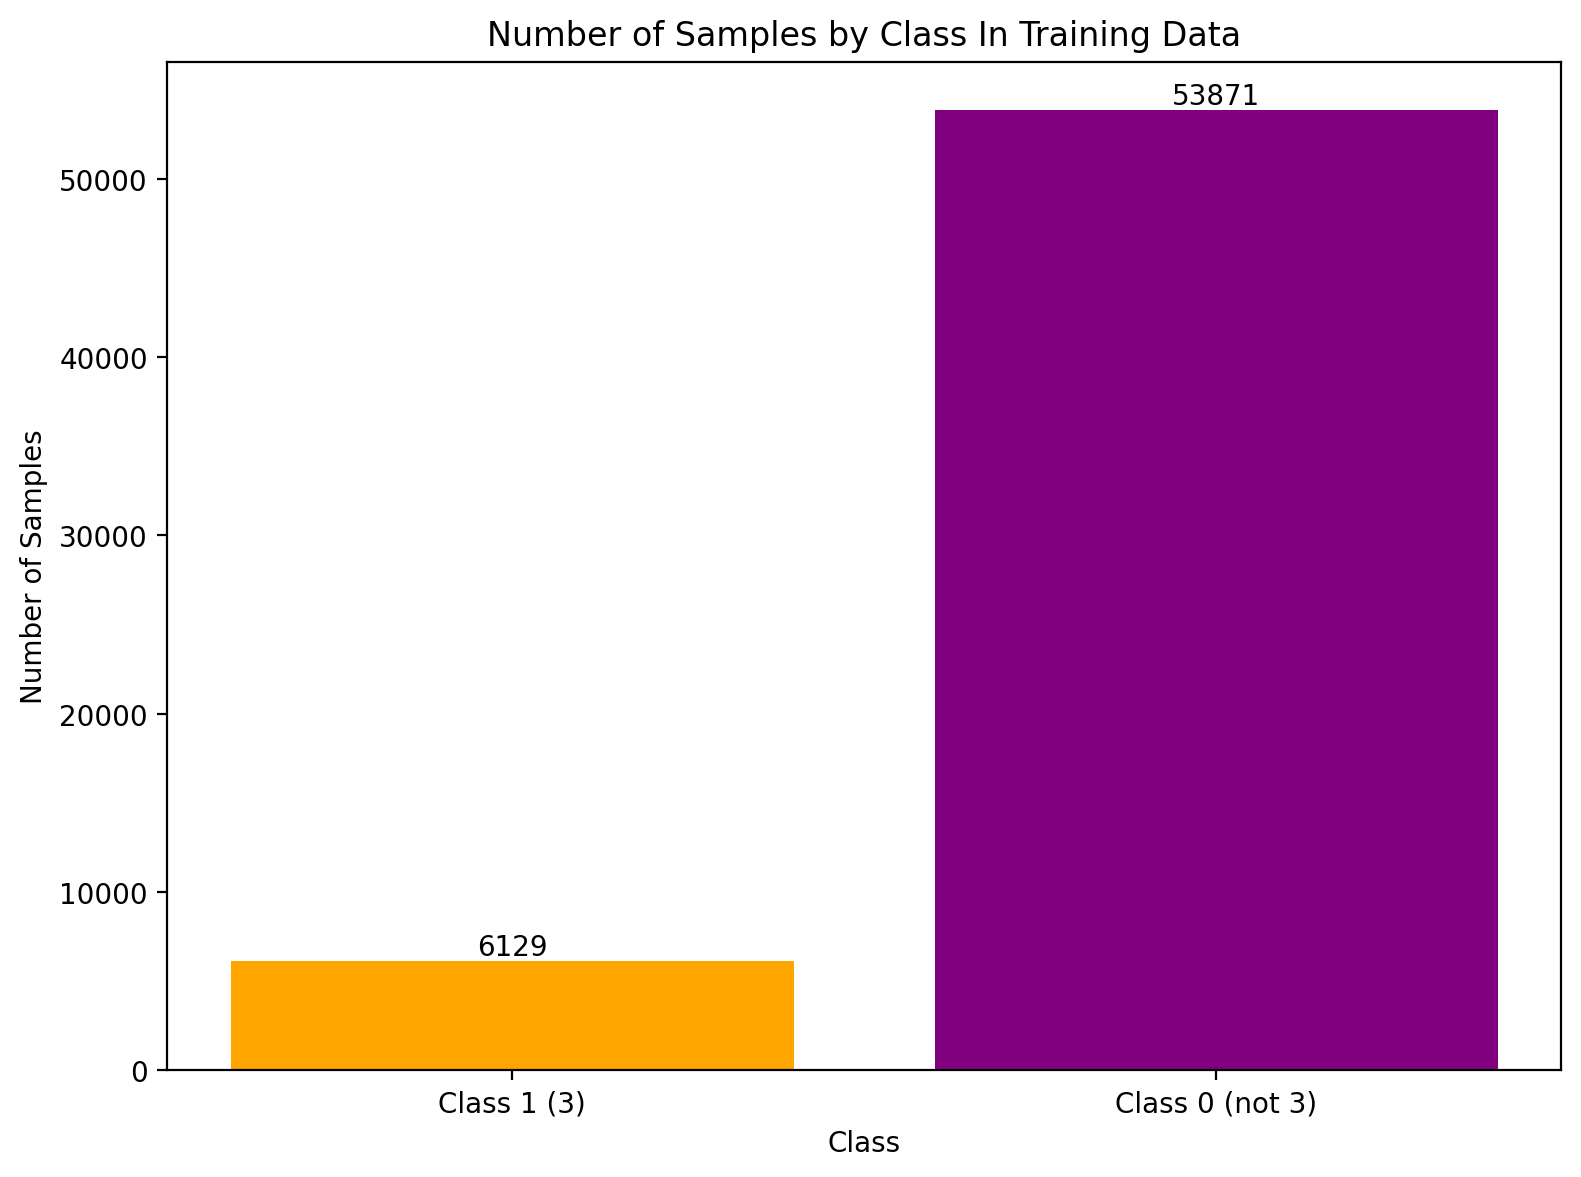

In [6]:
# Bar plot of samples by class

# define class and samples list
classes = ["Class 1 (3)", "Class 0 (not 3)"]
samples = [class_1.shape[0], class_0.shape[0]]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, samples, color=["orange", "purple"])

# Adding the count above the bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha="center", va="bottom"
    )

plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Number of Samples by Class In Training Data")
plt.tight_layout()
plt.show()

In [81]:
fraction_positive = class_1.shape[0] / (class_1.shape[0] + class_0.shape[0])
print(
    f"Fraction of samples that are positive being in Class 1 ('3') is around: {fraction_positive:.2%}"
)

Fraction of samples that are positive being in Class 1 ('3') is around: 10.21%


> - Number of examples in class 1 ('3') is 6129, and number of examples in class 0 (not '3') is 53871. The fraction of samples that are positive being in Class 1 ('3') is around 10.21%. 
> - It is an imbalanced dataset, where the number of samples in one class significantly outnumbers the samples in another class. Imbalanced dataset can lead to biased model that performs well on the majority class but performs poorly on the minority class. There's a risk of overfitting to the majority class while failing to generalize well to unseen data, especially for the minority class.

**(c)** Identify the value of the regularization parameter that optimizes model performance on out-of-sample data. Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance on the test set over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at least 20 different values of C. As you vary the regularization coefficient, Plot the following four quantities (this should result in 4 separate plots)... 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

In [82]:
# Generate 20 logarithmically spaced values for C between 10^-4 and 10^4
C_values = np.logspace(-4, 4, num=20)

print(f"20 logarithmically spaced values for C between 10^-4 and 10^4:")
print(C_values)

20 logarithmically spaced values for C between 10^-4 and 10^4:
[1.00000000e-04 2.63665090e-04 6.95192796e-04 1.83298071e-03
 4.83293024e-03 1.27427499e-02 3.35981829e-02 8.85866790e-02
 2.33572147e-01 6.15848211e-01 1.62377674e+00 4.28133240e+00
 1.12883789e+01 2.97635144e+01 7.84759970e+01 2.06913808e+02
 5.45559478e+02 1.43844989e+03 3.79269019e+03 1.00000000e+04]


In [84]:
# Evaluate L1 regularization strengths for reducing features in final model
# As C (1/λ) decreases, more coefficients go to zero

# create list to store the number of non-zero coefficients
nonzero_count_list = []
# create list to store the cross entropy loss
cross_entropy_loss_list = []
# create list to store the auc
auc_list = []
# create list to store the f1 score
f1_list = []

for c in C_values:
    # logistic regression with l1 penalty
    clf = LogisticRegression(penalty="l1", C=c, solver="liblinear", random_state=38)
    # fit the model with training data
    clf.fit(X_train, y_train)
    # predict testing data class labels
    y_pred = clf.predict(X_test)
    # get coefficients
    coefficients = np.array(clf.coef_)
    # count non zero coefficients
    nonzero_count = np.count_nonzero(coefficients)
    # get probability estimates for all classes
    clf_score = clf.predict_proba(X_test)
    # get probability estiamtes for positive class
    clf_score_positive = clf_score[:, 1]

    # Metrics calculation
    cross_entropy_loss = log_loss(y_test, clf_score)
    auc = roc_auc_score(y_test, clf_score_positive)
    f1 = f1_score(y_test, y_pred)

    # Store metrics
    nonzero_count_list.append(nonzero_count)
    cross_entropy_loss_list.append(cross_entropy_loss)
    auc_list.append(auc)
    f1_list.append(f1)

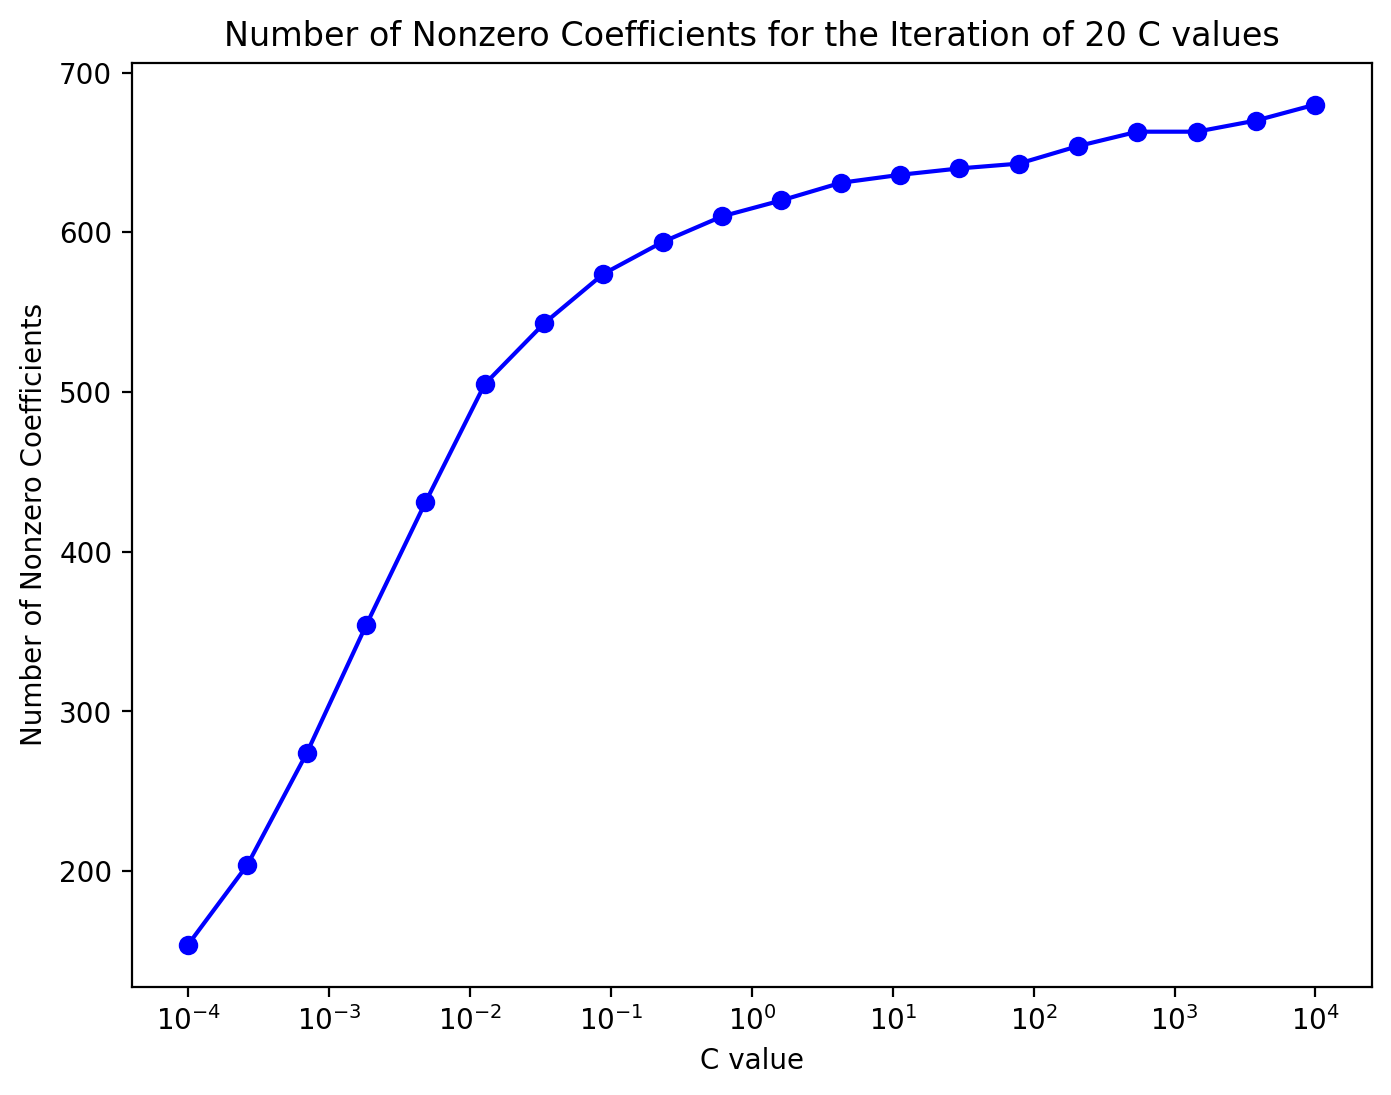

In [85]:
# Plotting the number of model parameters
# that are estimated to be nonzero
# for different values of C

# set figure size
plt.figure(figsize=(8, 6))

# plotting the number of nonzero coefficients
plt.plot(C_values, nonzero_count_list, marker="o", color="blue")
plt.xlabel("C value")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("Number of Nonzero Coefficients for the Iteration of 20 C values")
plt.xscale("log")  # Set the x-axis to a logarithmic scale

# Set x-ticks
tick_values = [10**i for i in range(-4, 5)]  # Generates 10^-4, 10^-3, ..., 10^4
plt.xticks(tick_values, labels=[f"$10^{{{i}}}$" for i in range(-4, 5)])

plt.show()

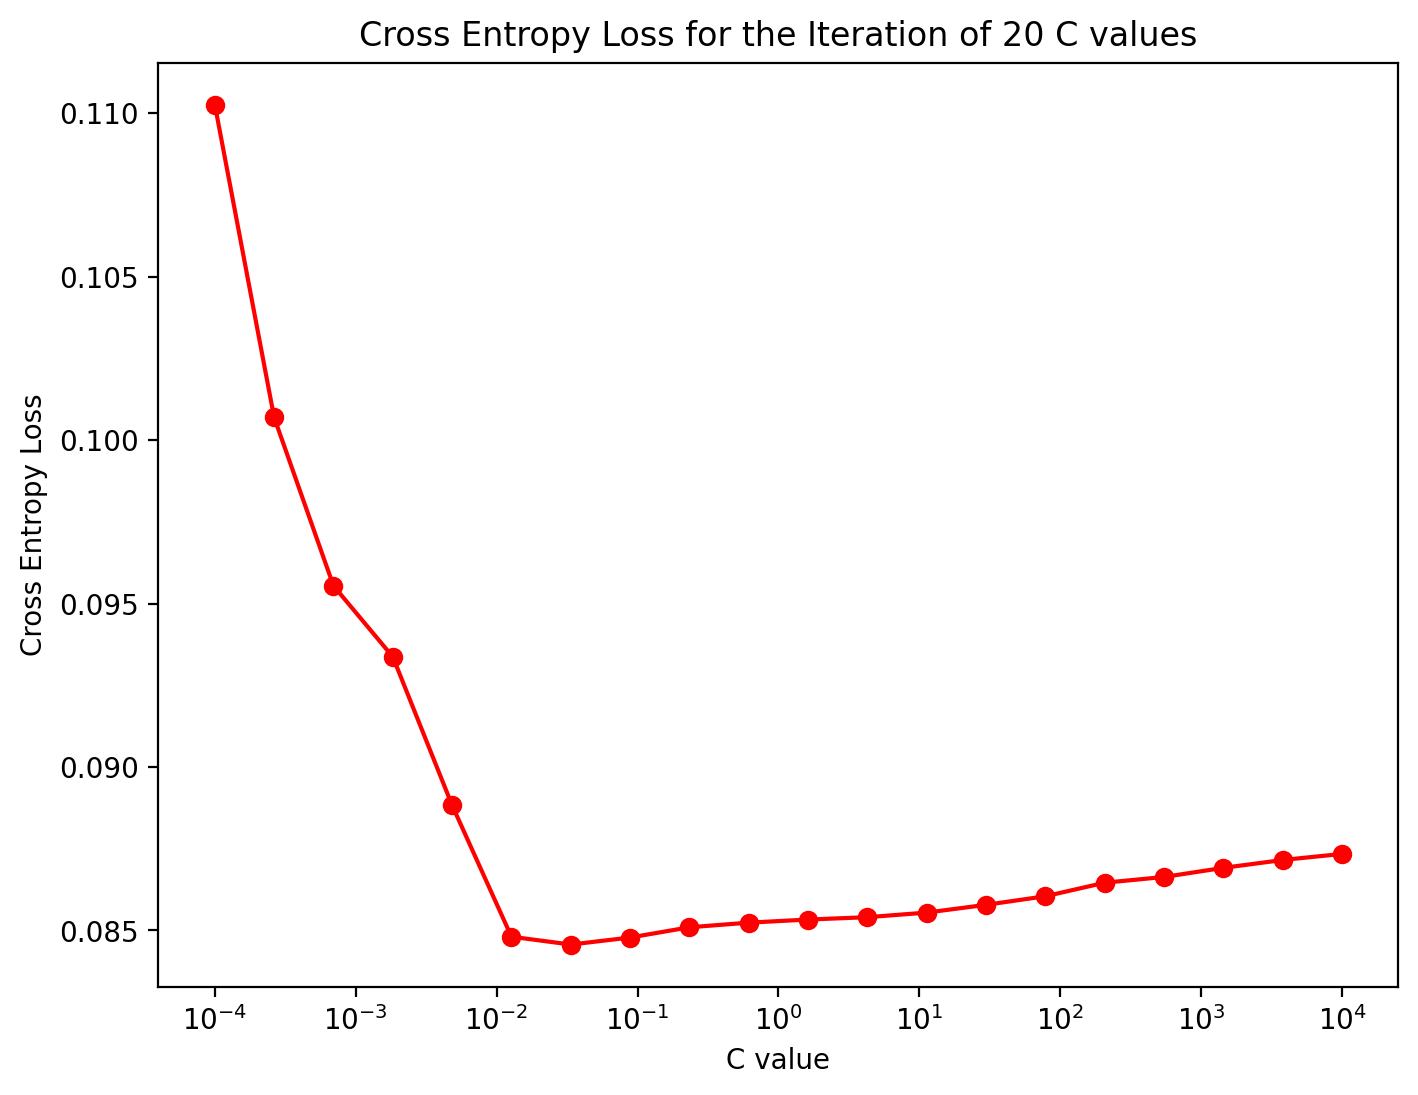

In [86]:
# Plotting the cross entropy loss for different values of C

# set figure size
plt.figure(figsize=(8, 6))

# Plotting the cross entropy loss
plt.plot(C_values, cross_entropy_loss_list, marker="o", color="red")
plt.xlabel("C value")
plt.ylabel("Cross Entropy Loss")
plt.title("Cross Entropy Loss for the Iteration of 20 C values")
plt.xscale("log")  # Set the x-axis to a logarithmic scale

# Set x-ticks
tick_values = [10**i for i in range(-4, 5)]  # Generates 10^-4, 10^-3, ..., 10^4
plt.xticks(tick_values, labels=[f"$10^{{{i}}}$" for i in range(-4, 5)])

plt.show()

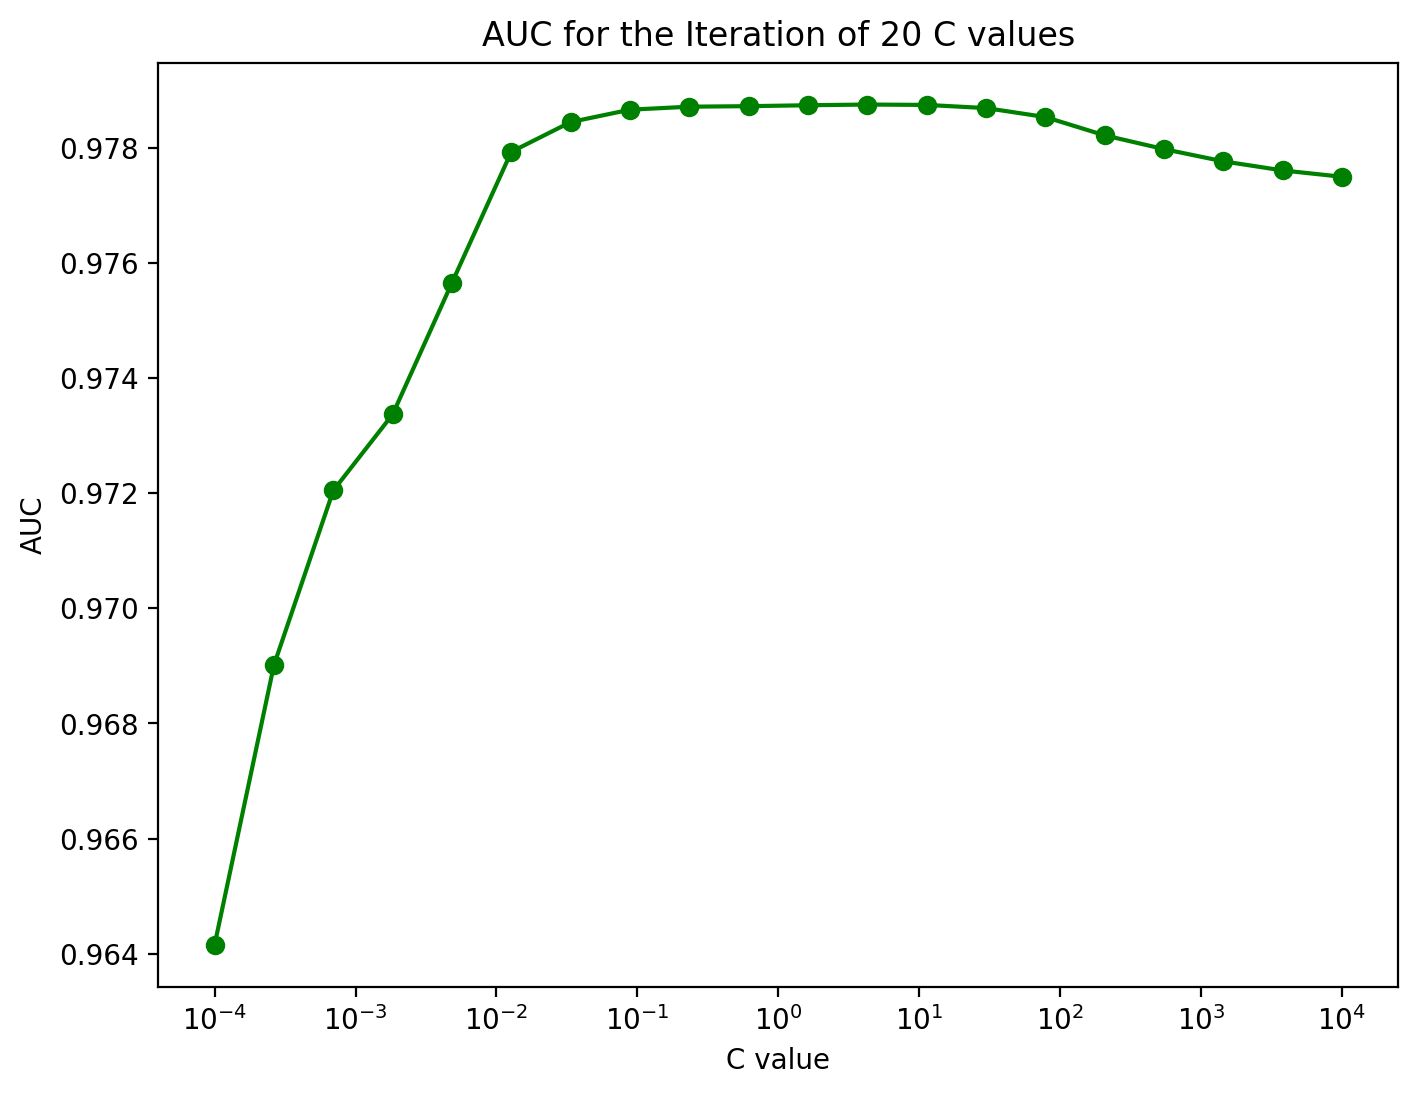

In [87]:
# Plotting the AUC for different values of C

# set figure size
plt.figure(figsize=(8, 6))

# Plotting the AUC
plt.plot(C_values, auc_list, marker="o", color="green")
plt.xlabel("C value")
plt.ylabel("AUC")
plt.title("AUC for the Iteration of 20 C values")
plt.xscale("log")  # Set the x-axis to a logarithmic scale

# Set x-ticks
tick_values = [10**i for i in range(-4, 5)]  # Generates 10^-4, 10^-3, ..., 10^4
plt.xticks(tick_values, labels=[f"$10^{{{i}}}$" for i in range(-4, 5)])

plt.show()

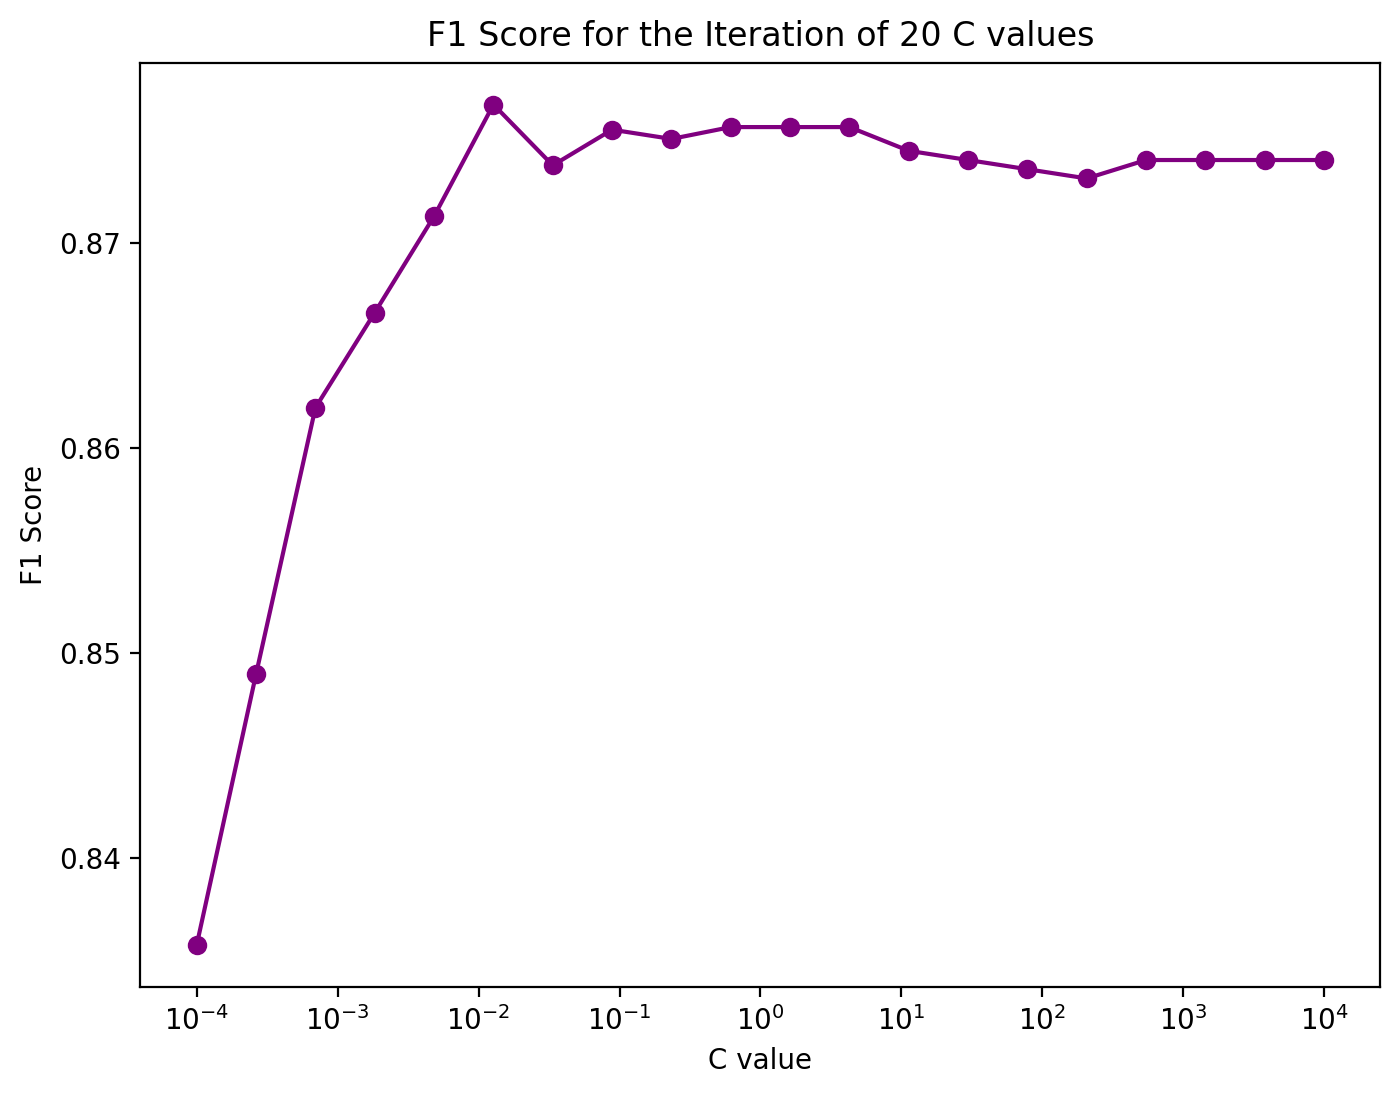

In [88]:
# Plotting the F-1 Score for different values of C

plt.figure(figsize=(8, 6))

# Plotting the F1 score
plt.plot(C_values, f1_list, marker="o", color="purple")
plt.xlabel("C value")
plt.ylabel("F1 Score")
plt.title("F1 Score for the Iteration of 20 C values")
plt.xscale("log")  # Set the x-axis to a logarithmic scale

# Set x-ticks
tick_values = [10**i for i in range(-4, 5)]  # Generates 10^-4, 10^-3, ..., 10^4
plt.xticks(tick_values, labels=[f"$10^{{{i}}}$" for i in range(-4, 5)])

plt.show()

> - In evaluating the optimal regularization parameter for a logistic regression classifier with lasso regularization, a value of \( C = 10^{-2} = 0.01 \) appears to be the most effective for this problem. This conclusion is drawn from the observation that \( C = 0.01 \) yields the highest F1 score, which is a critical metric for assessing performance on the imbalanced dataset, as it balances precision and recall.
> - Cross-entropy loss is commonly utilized as a cost function in binary classification scenarios. While cost functions guide the model fitting by optimizing parameters, we often select different performance metrics, such as accuracy and F1 scores, for evaluating the classification outcomes. For imbalanced datasets, the F1 score is particularly important, as it incorporates both precision and recall, unlike AUC and ROC curves, which might be misleading due to the disproportionate class distribution. 
> - Thus, \( C = 10^{-2} = 0.01 \) seems best for this problem, since it has the highest F1 score among all others, provides comprehensive insight into the model's performance when dealing with imbalanced classes.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. For the ROC curves, all your curves should be plotted on the same set of axes so that you can directly compare them. Please do the same wih the PR curves.
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead, you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise, your results may not converge.
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [7]:
# Train and test a logistic regression classifier
# with minimal regularization set penalty='l1', C=1e100
clf_minimal = LogisticRegression(
    penalty="l1", C=1e100, solver="liblinear", random_state=38
)

# fit the model to the training data
clf_minimal.fit(X_train, y_train)
# predict the labels of the test data
y_pred_minimal = clf_minimal.predict(X_test)

# get probability estimates for all classes
clf_minimal_score = clf_minimal.predict_proba(X_test)
# get probability estiamtes for positive class
clf_minimal_score_positive = clf_minimal_score[:, 1]

# Compute ROC curve
fpr_clf_minimal, tpr_clf_minimal, _ = roc_curve(y_test, clf_minimal_score_positive)
# Compute AUC score for ROC curve
clf_minimal_auc = roc_auc_score(y_test, clf_minimal_score_positive)
# Compute PR curve
precision_clf_minimal, recall_clf_minimal, _ = precision_recall_curve(
    y_test, clf_minimal_score_positive
)
# Compute AUC score for PR curve
clf_minimal_pr_auc = auc(recall_clf_minimal, precision_clf_minimal)

In [8]:
# Train and test a logistic regression classifier
# with the best value of the regularization parameter C=0.01
clf_best = LogisticRegression(penalty="l1", C=0.01, solver="liblinear", random_state=38)

# fit the model to the training data
clf_best.fit(X_train, y_train)
# predict the labels of the test data
y_pred_best = clf_best.predict(X_test)

# Get probability estimates for all classes
clf_best_score = clf_best.predict_proba(X_test)
# Get probability estimates for the positive class
clf_best_score_positive = clf_best_score[:, 1]

# Compute ROC curve
fpr_clf_best, tpr_clf_best, _ = roc_curve(y_test, clf_best_score_positive)
# Compute AUC score for ROC curve
clf_best_auc = roc_auc_score(y_test, clf_best_score_positive)
# Compute PR curve
precision_clf_best, recall_clf_best, _ = precision_recall_curve(
    y_test, clf_best_score_positive
)
# Compute AUC score for PR curve
clf_best_pr_auc = auc(recall_clf_best, precision_clf_best)

In [9]:
# Train and test a Linear Discriminant Analysis (LDA) Classifier
# using default parameters
clf_LDA = LinearDiscriminantAnalysis()

# fit the model to the training data
clf_LDA.fit(X_train, y_train)
# Predict the labels of the test data
y_pred_LDA = clf_LDA.predict(X_test)

# Get probability estimates for all classes
clf_LDA_score = clf_LDA.predict_proba(X_test)
# Get probability estimates for the positive class
clf_LDA_score_positive = clf_LDA_score[:, 1]

# Compute ROC curve
fpr_clf_LDA, tpr_clf_LDA, _ = roc_curve(y_test, clf_LDA_score_positive)
# Compute AUC score for ROC curve
clf_LDA_auc = roc_auc_score(y_test, clf_LDA_score_positive)
# Compute PR curve
precision_LDA, recall_LDA, _ = precision_recall_curve(y_test, clf_LDA_score_positive)
# Compute AUC score for PR curve
clf_LDA_pr_auc = auc(recall_LDA, precision_LDA)

In [10]:
# Train and test a Random Forest (RF) classifier
# using default parameters
clf_rf = RandomForestClassifier(random_state=38)

# fit the model to the training data
clf_rf.fit(X_train, y_train)
# Predict the labels of the test data
y_pred_rf = clf_rf.predict(X_test)

# Get probability estimates for all classes
clf_rf_score = clf_rf.predict_proba(X_test)
# Get probability estimates for the positive class
clf_rf_score_positive = clf_rf_score[:, 1]

# Compute ROC curve
fpr_clf_rf, tpr_clf_rf, _ = roc_curve(y_test, clf_rf_score_positive)
# Compute AUC score for ROC curve
clf_rf_auc = roc_auc_score(y_test, clf_rf_score_positive)
# Compute PR curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, clf_rf_score_positive)
# Compute AUC score for PR curve
clf_rf_pr_auc = auc(recall_rf, precision_rf)

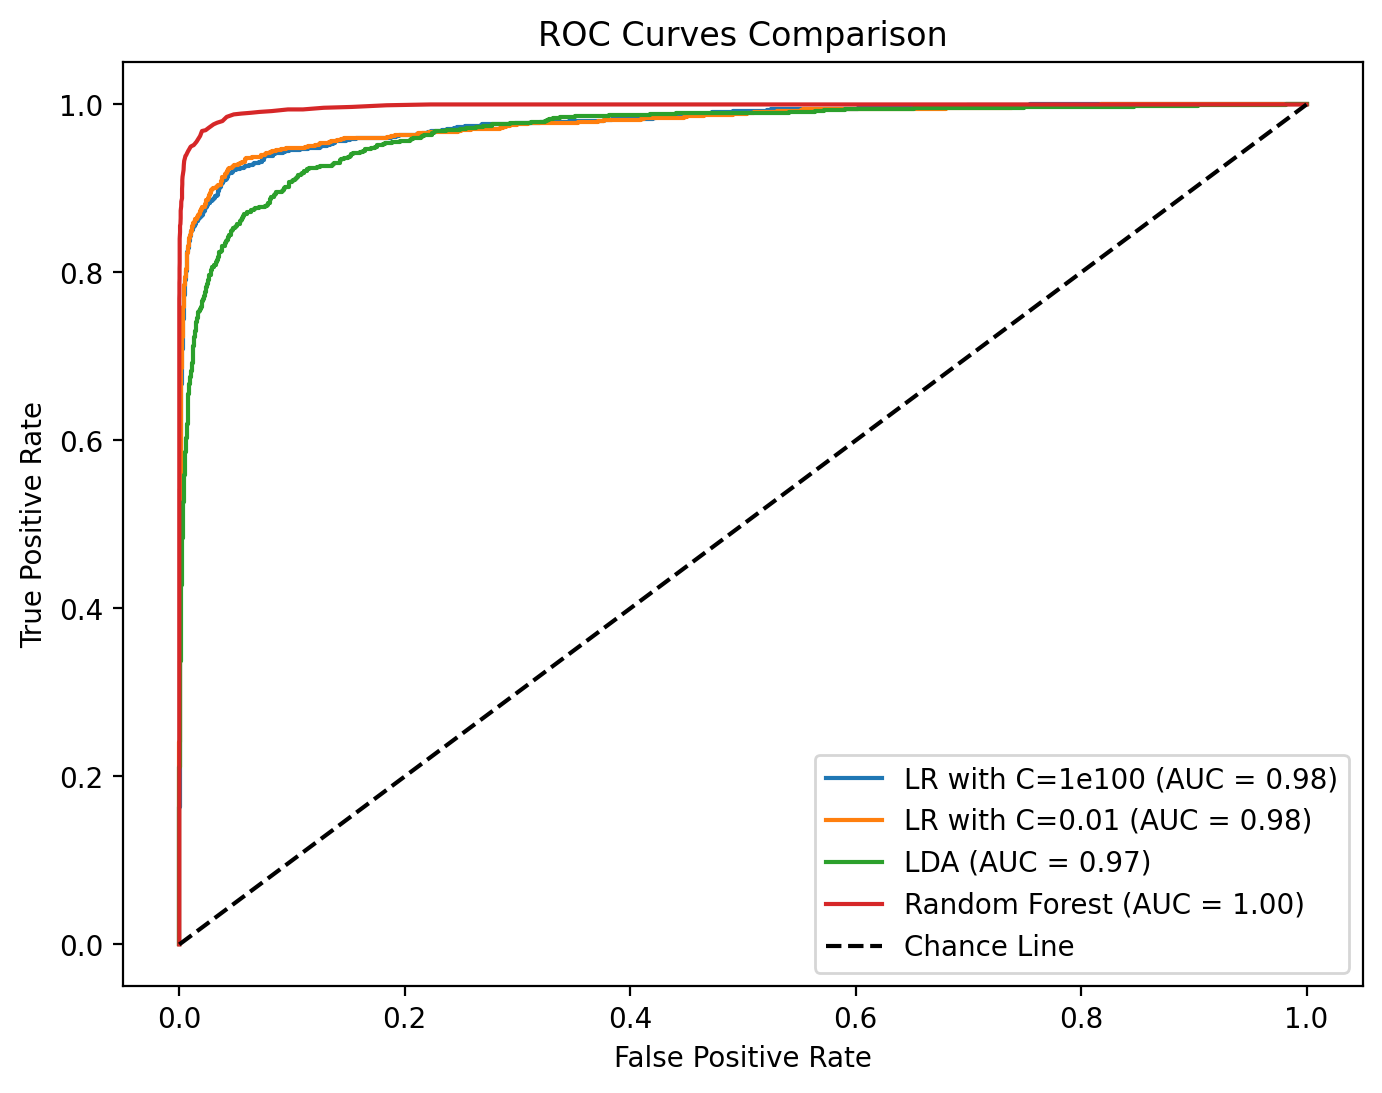

In [11]:
# Plotting ROC curve and AUC on the graph
plt.figure(figsize=(8, 6))

# Plot ROC curve for clf_minimal
plt.plot(
    fpr_clf_minimal,
    tpr_clf_minimal,
    label=f"LR with C=1e100 (AUC = {clf_minimal_auc:.2f})",
)

# Plot ROC curve for clf_best
plt.plot(fpr_clf_best, tpr_clf_best, label=f"LR with C=0.01 (AUC = {clf_best_auc:.2f})")

# Plot ROC curve for clf_LDA
plt.plot(fpr_clf_LDA, tpr_clf_LDA, label=f"LDA (AUC = {clf_LDA_auc:.2f})")

# Plot ROC curve for clf_rf
plt.plot(fpr_clf_rf, tpr_clf_rf, label=f"Random Forest (AUC = {clf_rf_auc:.2f})")

# Plot black chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance Line")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

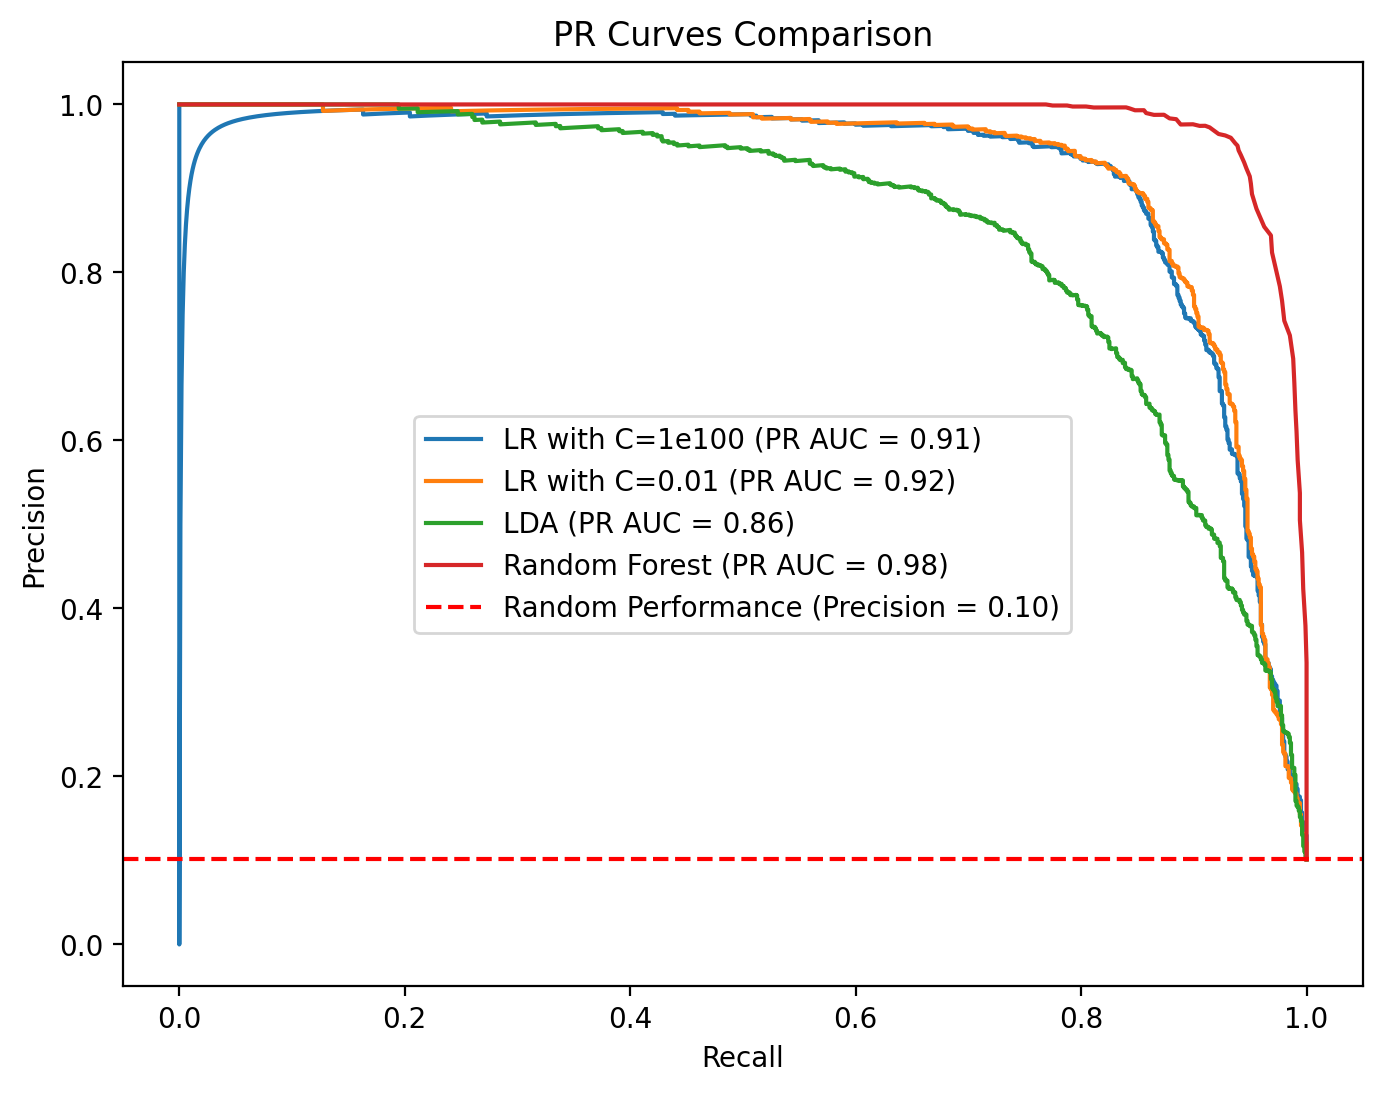

In [13]:
# Plotting PR Curve and AUC on the graph
plt.figure(figsize=(8, 6))

# Plot PR curve for clf_minimal
plt.plot(
    recall_clf_minimal,
    precision_clf_minimal,
    label=f"LR with C=1e100 (PR AUC = {clf_minimal_pr_auc:.2f})",
)

# Plot PR curve for clf_best
plt.plot(
    recall_clf_best,
    precision_clf_best,
    label=f"LR with C=0.01 (PR AUC = {clf_best_pr_auc:.2f})",
)

# Plot PR curve for clf_LDA
plt.plot(recall_LDA, precision_LDA, label=f"LDA (PR AUC = {clf_LDA_pr_auc:.2f})")

# Plot PR curve for clf_rf
plt.plot(recall_rf, precision_rf, label=f"Random Forest (PR AUC = {clf_rf_pr_auc:.2f})")

# Calculate and plot the random performance level line
P = sum(y_test == 1)
N = sum(y_test == 0)
random_classifier_precision = P / (P + N)
plt.axhline(
    y=random_classifier_precision,
    color="r",
    linestyle="--",
    label=f"Random Performance (Precision = {random_classifier_precision:.2f})",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curves Comparison")
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.5))
plt.show()

> - **ROC Curve Analysis:** The Random Forest classifier has a perfect AUC of 1.00, which suggests that it perfectly distinguishes between the two classes without any false positives or negatives. Both logistic regression models with different regularization strengths (C=1e100 and C=0.01) show almost identical performance with AUCs of 0.98. The LDA classifier has a slightly lower AUC of 0.97, which is still a high score, indicating very good performance.
> - **PR Curve Analysis:** The Random Forest classifier outperforming others with a PR AUC of 0.98. Logistic regression with C=0.01 has a PR AUC of 0.92, which is slightly higher than the one with C=1e100 (PR AUC = 0.91). The LDA classifier has the lowest PR AUC of 0.86 among the compared classifiers.
> - **Regularization Analysis:** Regularization on the logistic regression model doesn't make much difference here since (C=1e100 and C=0.01) has similar performance on both ROC and PR curve. However, it slightly improved the PR AUC, indicating better performance on the positive class which is usually of more interest in binary classification problems.
> - **Classifier Selection:** I would select random forest for the application to unseen data given its perfect score on the ROC curve and the highest PR AUC. It is the standout performer among all others.

---

## Citation 

Chou, S. (n.d.). Compute the AUC of Precision-Recall curve. https://sinyi-chou.github.io/python-sklearn-precision-recall/ 

Dash, S. K. (2023, May 5). Implementing Logistic Regression from Scratch using Python. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/02/implementing-logistic-regression-from-scratch-using-python/ 

Find optimal Lasso/L1 regularization strength using cross validation for logistic regression in scikit learn. (n.d.). Stack Overflow. https://stackoverflow.com/questions/62158976/find-optimal-lasso-l1-regularization-strength-using-cross-validation-for-logisti 

Koushik. (2023, August 28). Logistic regression from scratch - Koushik - medium. Medium. https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226 

Pytholabs Research. (2021, December 7). Logistic Regression from scratch in Python - Pytholabs Research - Medium. Medium. https://medium.com/@lope.ai/logistic-regression-from-scratch-in-python-d1e9dd51f85d 

Sudhirnl. (2023, May 27). Logistic Regression with StratifiedKfold. Kaggle. https://www.kaggle.com/code/sudhirnl7/logistic-regression-with-stratifiedkfold 

Thavanani, S. (2024, February 8). The derivative of cost function for logistic regression. Medium. https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d

I used ChatGPT to check my grammer in Question 1 (h) (i), Question 2 (b), (c), (d) with the prompt, “Revise the grammer in the following paragraph {}”
